In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pyqg_subgrid_experiments as pse
from functools import cache
import json
import glob
import pyqg
import itertools
%matplotlib inline
plt.rcParams.update({'font.size': 12})

In [2]:
possible_inputs = [
    'ddx_u,ddx_v,ddy_u,ddy_v',
    'q',
    'u,v',
]
inputs = list(set(reversed([','.join(set(s)) for s in itertools.combinations_with_replacement(possible_inputs,3)])))
inputs = [i for i in inputs if i != 'ddx_u,ddx_v,ddy_u,ddy_v,q,u,v']

inputs

['ddx_u,ddx_v,ddy_u,ddy_v',
 'u,v',
 'u,v,q',
 'q',
 'q,ddx_u,ddx_v,ddy_u,ddy_v',
 'u,v,q,ddx_u,ddx_v,ddy_u,ddy_v',
 'u,v,ddx_u,ddx_v,ddy_u,ddy_v']

In [3]:
@cache
def params_for(path):
    if 'zb2020' in path:
        return dict(inputs='u,v', targets='u_forcing_advection,v_forcing_advection', layerwise_inputs=0, layerwise_targets=0)
    try:
        with open(f"{path}/model_config.json", 'r') as f:
            d = json.loads(f.read())
            del d['save_dir']
            del d['train_set']
            del d['test_set']
            del d['transfer_set']
            del d['num_epochs']
            if 'zb2020' in d:
                del d['zb2020']
            del d['zero_mean']
            return d
    except FileNotFoundError:
        return {'inputs': ''}

In [4]:
model_paths = list(sorted(glob.glob('/scratch/zanna/data/pyqg/models/fcnn*zero*/0'), reverse=1))
model_paths = [m for m in model_paths if 'layerwise00' in m
               and ('zeromean0' in m if 'flux' in m else 'zeromean1' in m)
              and params_for(m)['inputs'] in inputs]
import os
model_paths = [m for m in model_paths if os.path.exists(m+'/model_config.json')]
model_paths = [m for m in model_paths
        if len(glob.glob(f"{m}/test/online_simulations/*.nc"))
    and  len(glob.glob(f"{m}/transfer/online_simulations/*.nc"))
    ]
model_paths += ['/scratch/zanna/data/pyqg/models/zb2020_1.0']
model_paths[:10], len(model_paths)

(['/scratch/zanna/data/pyqg/models/fcnn_u-v_uu_subgrid_flux-uv_subgrid_flux-vv_subgrid_flux_zeromean0_layerwise00/0',
  '/scratch/zanna/data/pyqg/models/fcnn_u-v_uq_subgrid_flux-vq_subgrid_flux_zeromean0_layerwise00/0',
  '/scratch/zanna/data/pyqg/models/fcnn_u-v_u_forcing_advection-v_forcing_advection_zeromean1_layerwise00/0',
  '/scratch/zanna/data/pyqg/models/fcnn_u-v_q_forcing_total_zeromean1_layerwise00/0',
  '/scratch/zanna/data/pyqg/models/fcnn_u-v_q_forcing_advection_zeromean1_layerwise00/0',
  '/scratch/zanna/data/pyqg/models/fcnn_u-v-ddx_u-ddx_v-ddy_u-ddy_v_u_forcing_advection-v_forcing_advection_zeromean1_layerwise00/0',
  '/scratch/zanna/data/pyqg/models/fcnn_q_uu_subgrid_flux-uv_subgrid_flux-vv_subgrid_flux_zeromean0_layerwise00/0',
  '/scratch/zanna/data/pyqg/models/fcnn_q_uq_subgrid_flux-vq_subgrid_flux_zeromean0_layerwise00/0',
  '/scratch/zanna/data/pyqg/models/fcnn_q_u_forcing_advection-v_forcing_advection_zeromean1_layerwise00/0',
  '/scratch/zanna/data/pyqg/models/f

In [5]:
test = pse.Dataset('/scratch/zanna/data/pyqg/data/test/*.nc').isel(run=slice(-5,None)).load()
xfer = pse.Dataset('/scratch/zanna/data/pyqg/data/transfer/*.nc').isel(run=slice(-5,None)).load()

hires_test = pse.Dataset('/scratch/zanna/data/pyqg/datasets/test/*/hires.nc').assign_attrs(plot_kwargs=dict(label='Hi-res')).isel(run=slice(-5,None)).load()
lores_test = pse.Dataset('/scratch/zanna/data/pyqg/datasets/test/*/control.nc').assign_attrs(plot_kwargs=dict(label='Lo-res')).isel(run=slice(-5,None)).load()

hires_xfer = pse.Dataset('/scratch/zanna/data/pyqg/datasets/transfer/*/hires.nc').assign_attrs(plot_kwargs=dict(label='Hi-res')).isel(run=slice(-5,None)).load()
lores_xfer = pse.Dataset('/scratch/zanna/data/pyqg/datasets/transfer/*/control.nc').assign_attrs(plot_kwargs=dict(label='Lo-res')).isel(run=slice(-5,None)).load()

In [7]:
def decorrelation_timescale(self, other, **kw):
    if True:
        import pyqg
        params1 = dict(self.pyqg_params)
        params2 = dict(pse.Dataset.wrap(other).pyqg_params)
        
        m1 = pyqg.QGModel(**params1)
        m1.set_q1q2(*self.final_q)
        m1._invert()
        
        m2 = pyqg.QGModel(**params2)
        
        return pse.time_until_uncorrelated(m1, m2, **kw)

In [16]:
decorrelation_timescale(hires_test, lores_test)

INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 5.90e-04, CFL: 0.242
INFO: Step: 1000, Time: 3.60e+06, KE: 4.65e-04, CFL: 0.049


1809

In [17]:
decorrelation_timescale(hires_xfer, lores_xfer)

INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 1.66e-04, CFL: 0.180
INFO: Step: 1000, Time: 3.60e+06, KE: 1.39e-04, CFL: 0.034
INFO: Step: 2000, Time: 7.20e+06, KE: 1.76e-04, CFL: 0.176
INFO: Step: 2000, Time: 7.20e+06, KE: 1.49e-04, CFL: 0.035
INFO: Step: 3000, Time: 1.08e+07, KE: 1.87e-04, CFL: 0.169
INFO: Step: 3000, Time: 1.08e+07, KE: 1.61e-04, CFL: 0.037
INFO: Step: 4000, Time: 1.44e+07, KE: 1.89e-04, CFL: 0.168
INFO: Step: 4000, Time: 1.44e+07, KE: 1.70e-04, CFL: 0.040


4512

In [8]:
lores_diffs_test = hires_test.distributional_distances(lores_test)
lores_diffs_test['decorrelation_timescale']=1809
lores_diffs_test


defaultdict(dict,
            {'q1_wasserstein_distance': 8.45297538940099e-07,
             'u1_wasserstein_distance': 0.004100228227289772,
             'v1_wasserstein_distance': 0.0029825048373929683,
             'ke1_wasserstein_distance': 0.000516918975134468,
             'en1_wasserstein_distance': 8.667306240377742e-12,
             'q2_wasserstein_distance': 1.0974086328668939e-07,
             'u2_wasserstein_distance': 0.001320702694666466,
             'v2_wasserstein_distance': 0.0008165760392246762,
             'ke2_wasserstein_distance': 2.250589865538306e-05,
             'en2_wasserstein_distance': 1.0376035224795807e-13,
             'KEspec1_curve_rmse': 3.096433429227904e-10,
             'KEspec1_slope_diff': -0.7069219537806775,
             'KEspec2_curve_rmse': 1.3188012909916534e-11,
             'KEspec2_slope_diff': -0.28207116843420277,
             'Ensspec1_curve_rmse': 4.2380924177161296e-18,
             'Ensspec1_slope_diff': -0.7071993318350644,
   

In [9]:
lores_diffs_xfer = hires_xfer.distributional_distances(lores_xfer)
lores_diffs_xfer['decorrelation_timescale'] = 4512
lores_diffs_xfer

defaultdict(dict,
            {'q1_wasserstein_distance': 9.919691822621419e-07,
             'u1_wasserstein_distance': 0.004841676560337392,
             'v1_wasserstein_distance': 0.004086588286691621,
             'ke1_wasserstein_distance': 0.000592713144347908,
             'en1_wasserstein_distance': 6.781933477832097e-12,
             'q2_wasserstein_distance': 1.9640334974721536e-08,
             'u2_wasserstein_distance': 0.0007299049987101685,
             'v2_wasserstein_distance': 0.0010888976398976053,
             'ke2_wasserstein_distance': 1.640129763534436e-05,
             'en2_wasserstein_distance': 3.786111653659107e-14,
             'KEspec1_curve_rmse': 1.7392285560033854e-10,
             'KEspec1_slope_diff': -0.3043386768948433,
             'KEspec2_curve_rmse': 9.853715768720312e-12,
             'KEspec2_slope_diff': -0.376326799262249,
             'Ensspec1_curve_rmse': 2.9305955861210385e-18,
             'Ensspec1_slope_diff': -0.3058220463515222,
     

In [25]:

import pandas as pd

lores_diffs_test= {'q1_wasserstein_distance': 8.45297538940099e-07,
             'u1_wasserstein_distance': 0.004100228227289772,
             'v1_wasserstein_distance': 0.0029825048373929683,
             'ke1_wasserstein_distance': 0.000516918975134468,
             'en1_wasserstein_distance': 8.667306240377742e-12,
             'q2_wasserstein_distance': 1.0974086328668939e-07,
             'u2_wasserstein_distance': 0.001320702694666466,
             'v2_wasserstein_distance': 0.0008165760392246762,
             'ke2_wasserstein_distance': 2.250589865538306e-05,
             'en2_wasserstein_distance': 1.0376035224795807e-13,
             'KEspec1_curve_rmse': 3.096433429227904e-10,
             'KEspec1_slope_diff': -0.7069219537806775,
             'KEspec2_curve_rmse': 1.3188012909916534e-11,
             'KEspec2_slope_diff': -0.28207116843420277,
             'Ensspec1_curve_rmse': 4.2380924177161296e-18,
             'Ensspec1_slope_diff': -0.7071993318350644,
             'Ensspec2_curve_rmse': 7.032130704481579e-20,
             'Ensspec2_slope_diff': -0.17515406510224985,
             'APEgenspec_curve_rmse': 3.7704730206360776e-18,
             'APEflux_curve_rmse': 1.0803283464188548e-17,
             'KEflux_curve_rmse': 1.4180009162204794e-17,
             'Dissipation_curve_rmse': 6.1055224567749585e-18,
             'decorrelation_timescale': 1809}
lores_diffs_xfer={'q1_wasserstein_distance': 9.919691822621419e-07,
             'u1_wasserstein_distance': 0.004841676560337392,
             'v1_wasserstein_distance': 0.004086588286691621,
             'ke1_wasserstein_distance': 0.000592713144347908,
             'en1_wasserstein_distance': 6.781933477832097e-12,
             'q2_wasserstein_distance': 1.9640334974721536e-08,
             'u2_wasserstein_distance': 0.0007299049987101685,
             'v2_wasserstein_distance': 0.0010888976398976053,
             'ke2_wasserstein_distance': 1.640129763534436e-05,
             'en2_wasserstein_distance': 3.786111653659107e-14,
             'KEspec1_curve_rmse': 1.7392285560033854e-10,
             'KEspec1_slope_diff': -0.3043386768948433,
             'KEspec2_curve_rmse': 9.853715768720312e-12,
             'KEspec2_slope_diff': -0.376326799262249,
             'Ensspec1_curve_rmse': 2.9305955861210385e-18,
             'Ensspec1_slope_diff': -0.3058220463515222,
             'Ensspec2_curve_rmse': 2.8140287168295e-21,
             'Ensspec2_slope_diff': -0.3525274878660485,
             'APEgenspec_curve_rmse': 4.21502097951362e-19,
             'APEflux_curve_rmse': 8.556931857482218e-19,
             'KEflux_curve_rmse': 9.235127718821355e-19,
             'Dissipation_curve_rmse': 6.270546398276562e-19,
             'decorrelation_timescale': 4512}

@cache
def load_preds(path, dataset_name='test'):
    return xr.open_dataset(f"{path}/{dataset_name}/offline_metrics.nc")
def prediction_targets(ds):
    return [k.replace('_predictions', '') for k in ds.keys() if '_predictions' in k]


if True:
    subs = {
        'u1_wasserstein_distance_ratio': r"$\mathrm{Sim}^{\mathrm{dist}}_{u_1}$",
        'u2_wasserstein_distance_ratio': r"$\mathrm{Sim}^{\mathrm{dist}}_{u_2}$",
        'v1_wasserstein_distance_ratio': r"$\mathrm{Sim}^{\mathrm{dist}}_{v_1}$",
        'v2_wasserstein_distance_ratio': r"$\mathrm{Sim}^{\mathrm{dist}}_{v_2}$",
        'q1_wasserstein_distance_ratio': r"$\mathrm{Sim}^{\mathrm{dist}}_{q_1}$",
        'q2_wasserstein_distance_ratio': r"$\mathrm{Sim}^{\mathrm{dist}}_{q_2}$",
        'ke1_wasserstein_distance_ratio': r"$\mathrm{Sim}^{\mathrm{dist}}_{\mathrm{KE}_1}$",
        'ke2_wasserstein_distance_ratio': r"$\mathrm{Sim}^{\mathrm{dist}}_{\mathrm{KE}_2}$",
        'KEspec1_loglog_slope_difference_ratio': r"$\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$",
        'KEspec2_loglog_slope_difference_ratio': r"$\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$",
        'Ensspec1_loglog_slope_difference_ratio': r"$\mathrm{Sim}^{\mathrm{slope}}_{\mathcal{E}_1}$",
        'Ensspec2_loglog_slope_difference_ratio': r"$\mathrm{Sim}^{\mathrm{slope}}_{\mathcal{E}_2}$",
        'KEspec1_mean_difference_ratio': r"$\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$",
        'KEspec2_mean_difference_ratio': r"$\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$",
        'Ensspec1_mean_difference_ratio': r"$\mathrm{Sim}^{\mathrm{curve}}_{\mathcal{E}_1}$",
        'Ensspec2_mean_difference_ratio': r"$\mathrm{Sim}^{\mathrm{curve}}_{\mathcal{E}_2}$",
        'uu_subgrid_flux,uv_subgrid_flux,vv_subgrid_flux': "$\phi_{\mathbf{u}}^{adv}$",
        'q_forcing_advection': "$S_q^{adv}$",
        'q_forcing_total': "$S_q^{tot}$",
        'uq_subgrid_flux,vq_subgrid_flux': "$\phi_{q}^{adv}$",
        'u_forcing_advection,v_forcing_advection': "$S_{\mathbf{u}}^{adv}$",
        'u,v': "$\overline{\mathbf{u}}$",
        'q,': "$\overline{q}$,",
        'ddx_u,ddx_v,ddy_u,ddy_v': r"$\overline{\nabla}^T \overline{u}$",
    }
    def munge(k):
        k = str(k)
        k = k.replace('inputs','x').replace('targets','y').replace('_through_lores','')
        for key,val in subs.items():
            k = k.replace(key,val)
        if k == 'q':
            return "$\overline{q}$"
        return k
    
def compare_offline_metrics(paths, domain='test'):
    preds = [load_preds(p, domain) for p in paths]
    commonalities, labels = labels_for(paths)
    targets = prediction_targets(preds[0])
    metrics = ['correlation', 'mse', 'skill']
    with pse.plot_helpers.figure_grid(len(targets)*len(metrics), 2, rowwidth=10, rowheight=4) as g:
        g.title(f"Offline metrics, {domain}, {commonalities}", y=1.01)
        for t in targets:
            for m in metrics:
                for z in range(len(preds[0].lev)):
                    g.next(title=f"{t} {m} z={z}")
                    for label, ds in zip(labels, preds):
                        plt.plot(ds[f"{t}_temporal_{m}"].isel(lev=z), label=label)
                    plt.legend(loc='best', fontsize=10)
                    plt.xlabel("Time")
                    plt.ylabel(m)
                    if 'skill' in m:
                        plt.ylim(-5,1.5)
                        plt.axhline(1, ls='--', color='gray')
                    elif 'corr' in m:
                        plt.ylim(-1.05, 1.05)
                        plt.axhline(1, ls='--', color='gray')

def labels_for(paths):
    diff_keys = []
    sim_keys = []
    params = [params_for(p) for p in paths]
    
    for k in params[0].keys():
        if len(set(p[k] for p in params)) > 1:
            diff_keys.append(k)
        else:
            sim_keys.append(k)

    sim = ", ".join([f"{munge(k)}={munge(params[0][k])}" for k in sim_keys])
    diffs = [", ".join([f"{munge(k)}={munge(p[k])}" for k in diff_keys]) for p in params]
    return sim, diffs

@cache
def online_metrics_for(path, dataset_name='test'):
    with open(f"{path}/hires_{dataset_name}_diffs.json", 'r') as f:
        d = json.loads(f.read())
        if dataset_name=='test':
            comp = lores_diffs_test
        elif dataset_name =='transfer':
            comp = lores_diffs_xfer
        else:
            assert(False)
        keys = list(d.keys())
        for k in keys:
            if k in comp:
                try:
                    d[k+"_ratio"] = 1 - np.abs(d[k] / (comp[k]))
                except:
                    d[k+"_ratio"] = np.nan
        return d
    
@cache
def simulations_for(path, dataset_name='test'):
    ds = pse.Dataset(f"{path}/{dataset_name}/online_simulations/*.nc")
    ds.ds = ds.ds.isel(run=slice(-5,None)).load()
    return ds

def sims_for(p,**kw):
    df = simulations_for(p,**kw)
    if 'zb2020' in p:
        return df.assign_attrs(label='ZB2020')
    par = params_for(p)
    lab = f"FCNN({munge(par['inputs'])}$\\to${munge(par['targets'])})"
    return df.assign_attrs(label=lab)

@cache
def all_metrics(p,**kw):
    m = { 
        'correlation': np.array(load_preds(p,**kw).correlation.mean()).mean().round(3),
        'r2': np.array(load_preds(p,**kw).skill.mean()).mean().round(3),
    }
    m.update(online_metrics_for(p,**kw))
    return m
    
def get_rows(paths,metrics=['correlation','r2'],**kw):
    common, labels = labels_for(paths)
        
    def getx(l):
        return l.split(', y=')[0].replace('x=','')
    
    def gety(l):
        return l.split(', y=')[1].split(', zero_mean')[0]
    
    def get(d, keys):
        res = {}
        for k in keys:
            res[k] = d.get(k, np.nan)
        return res
    
    return [
        dict(x=getx(l), y=gety(l), path=p, **get(all_metrics(p,**kw), metrics)) for p,l in zip(paths,labels)
    ]

def construct_table(paths,metrics=['correlation','r2'],**kw):
    df = pd.DataFrame.from_dict(get_rows(paths, metrics, **kw))
    df = df.pivot_table(index='x', columns=['y'],
               values=[munge(m) for m in metrics]).reset_index()
    df.columns = df.columns.swaplevel(0, 1)
    df.sort_index(axis=1, level=0, inplace=True)
    return df

In [9]:
for m in model_paths:
    if not os.path.exists(f"{m}/hires_test_diffs.json"):
        sims = simulations_for(m)
        diffs = sims.distributional_distances(hires_test)
        print(m)
        with open(f"{m}/hires_test_diffs.json", 'w') as f:
            f.write(json.dumps(diffs))

In [12]:
for m in model_paths:
    if not os.path.exists(f"{m}/hires_transfer_diffs.json"):
        sims = simulations_for(m, 'transfer')
        diffs = sims.distributional_distances(hires_xfer)
        print(m)
        with open(f"{m}/hires_transfer_diffs.json", 'w') as f:
            f.write(json.dumps(diffs))

In [15]:
mets =list([k for k in all_metrics(model_paths[0]).keys() if 
                        ('curve_rmse_ratio' in k or 'wasserstein_distance_ratio' in k or 'r2' in k or 'slope_diff_ratio' in k or 'corr' in k)
                        and 'paramspec' not in k
                        and 'v1_was' not in k
                       and 'v2_was' not in k
               and 'vorticity' not in k
           and 'entspec' not in k])
mets = ['correlation',
 'r2',
 'q1_wasserstein_distance_ratio',
 'u1_wasserstein_distance_ratio',
 'ke1_wasserstein_distance_ratio',
 'en1_wasserstein_distance_ratio',
 'q2_wasserstein_distance_ratio',
 'u2_wasserstein_distance_ratio',
 'ke2_wasserstein_distance_ratio',
 'en2_wasserstein_distance_ratio',
 'KEspec1_slope_diff_ratio',
 'Ensspec1_slope_diff_ratio',
 'KEspec2_slope_diff_ratio',
 'Ensspec2_slope_diff_ratio',
 'KEspec1_curve_rmse_ratio',
 'Ensspec1_curve_rmse_ratio',
 'KEspec2_curve_rmse_ratio',
 'Ensspec2_curve_rmse_ratio',
 'APEgenspec_curve_rmse_ratio',
 'APEflux_curve_rmse_ratio',
 'KEflux_curve_rmse_ratio',
 'Dissipation_curve_rmse_ratio']
mets, len(mets)

(['correlation',
  'r2',
  'q1_wasserstein_distance_ratio',
  'u1_wasserstein_distance_ratio',
  'ke1_wasserstein_distance_ratio',
  'en1_wasserstein_distance_ratio',
  'q2_wasserstein_distance_ratio',
  'u2_wasserstein_distance_ratio',
  'ke2_wasserstein_distance_ratio',
  'en2_wasserstein_distance_ratio',
  'KEspec1_slope_diff_ratio',
  'Ensspec1_slope_diff_ratio',
  'KEspec2_slope_diff_ratio',
  'Ensspec2_slope_diff_ratio',
  'KEspec1_curve_rmse_ratio',
  'Ensspec1_curve_rmse_ratio',
  'KEspec2_curve_rmse_ratio',
  'Ensspec2_curve_rmse_ratio',
  'APEgenspec_curve_rmse_ratio',
  'APEflux_curve_rmse_ratio',
  'KEflux_curve_rmse_ratio',
  'Dissipation_curve_rmse_ratio'],
 22)

In [26]:
tab = get_rows(model_paths,metrics=mets)
tab = list(sorted(tab, key=lambda r: np.median([r[m] for m in mets]), reverse=True))
xs = []
ys = []
for t in tab:
    if t['x'] not in xs: xs.append(t['x'])
    if t['y'] not in ys: 

xs = list(set(t['x'] for t in tab))
ys = list(set(t['y'] for t in tab))

In [27]:
df = pd.DataFrame.from_dict(tab)
df

x  \
0                                      $\overline{q}$   
1   $\overline{\mathbf{u}}$,$\overline{\nabla}^T \...   
2                             $\overline{\mathbf{u}}$   
3   $\overline{q}$,$\overline{\nabla}^T \overline{u}$   
4   $\overline{q}$,$\overline{\nabla}^T \overline{u}$   
5   $\overline{q}$,$\overline{\nabla}^T \overline{u}$   
6   $\overline{q}$,$\overline{\nabla}^T \overline{u}$   
7   $\overline{q}$,$\overline{\nabla}^T \overline{u}$   
8                  $\overline{\nabla}^T \overline{u}$   
9                                      $\overline{q}$   
10                            $\overline{\mathbf{u}}$   
11                 $\overline{\nabla}^T \overline{u}$   
12                                     $\overline{q}$   
13                            $\overline{\mathbf{u}}$   
14                            $\overline{\mathbf{u}}$   
15                 $\overline{\nabla}^T \overline{u}$   
16                            $\overline{\mathbf{u}}$   
17                 $\overline{\nabla}^T \overline{u}$   
18                                     $\overline{q}$   
19                                     $\overline{q}$   
20                            $\overline{\mathbf{u}}$   
21                 $\overline{\nabla}^T \overline{u}$   

                            y  \
0      $S_{\mathbf{u}}^{adv}$   
1      $S_{\mathbf{u}}^{adv}$   
2      $S_{\mathbf{u}}^{adv}$   
3   $\phi_{\mathbf{u}}^{adv}$   
4            $\phi_{q}^{adv}$   
5      $S_{\mathbf{u}}^{adv}$   
6                 $S_q^{tot}$   
7                 $S_q^{adv}$   
8      $S_{\mathbf{u}}^{adv}$   
9                 $S_q^{adv}$   
10                $S_q^{tot}$   
11  $\phi_{\mathbf{u}}^{adv}$   
12  $\phi_{\mathbf{u}}^{adv}$   
13  $\phi_{\mathbf{u}}^{adv}$   
14                $S_q^{adv}$   
15                $S_q^{adv}$   
16           $\phi_{q}^{adv}$   
17           $\phi_{q}^{adv}$   
18           $\phi_{q}^{adv}$   
19                $S_q^{tot}$   
20     $S_{\mathbf{u}}^{adv}$   
21                $S_q^{tot}$   

                                                 path  correlation     r2  \
0   /scratch/zanna/data/pyqg/models/fcnn_q_u_forci...        0.959  0.920   
1   /scratch/zanna/data/pyqg/models/fcnn_u-v-ddx_u...        0.974  0.949   
2   /scratch/zanna/data/pyqg/models/fcnn_u-v_u_for...        0.969  0.939   
3   /scratch/zanna/data/pyqg/models/fcnn_q-ddx_u-d...        0.992  0.989   
4   /scratch/zanna/data/pyqg/models/fcnn_q-ddx_u-d...        0.993  0.986   
5   /scratch/zanna/data/pyqg/models/fcnn_q-ddx_u-d...        0.973  0.947   
6   /scratch/zanna/data/pyqg/models/fcnn_q-ddx_u-d...        0.955  0.912   
7   /scratch/zanna/data/pyqg/models/fcnn_q-ddx_u-d...        0.956  0.915   
8   /scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx...        0.973  0.946   
9   /scratch/zanna/data/pyqg/models/fcnn_q_q_forci...        0.941  0.886   
10  /scratch/zanna/data/pyqg/models/fcnn_u-v_q_for...        0.947  0.898   
11  /scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx...        0.991  0.989   
12  /scratch/zanna/data/pyqg/models/fcnn_q_uu_subg...        0.986  0.982   
13  /scratch/zanna/data/pyqg/models/fcnn_u-v_uu_su...        0.991  0.988   
14  /scratch/zanna/data/pyqg/models/fcnn_u-v_q_for...        0.948  0.899   
15  /scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx...        0.955  0.912   
16  /scratch/zanna/data/pyqg/models/fcnn_u-v_uq_su...        0.991  0.983   
17  /scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx...        0.991  0.983   
18  /scratch/zanna/data/pyqg/models/fcnn_q_uq_subg...        0.987  0.976   
19  /scratch/zanna/data/pyqg/models/fcnn_q_q_forci...        0.941  0.886   
20         /scratch/zanna/data/pyqg/models/zb2020_1.0        0.965  0.932   
21  /scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx...        0.955  0.913   

    q1_wasserstein_distance_ratio  u1_wasserstein_distance_ratio  \
0                        0.682089                       0.770536   
1                        0.746006                       0.688170   
2   

Text(0, 0.5, 'Metric value')

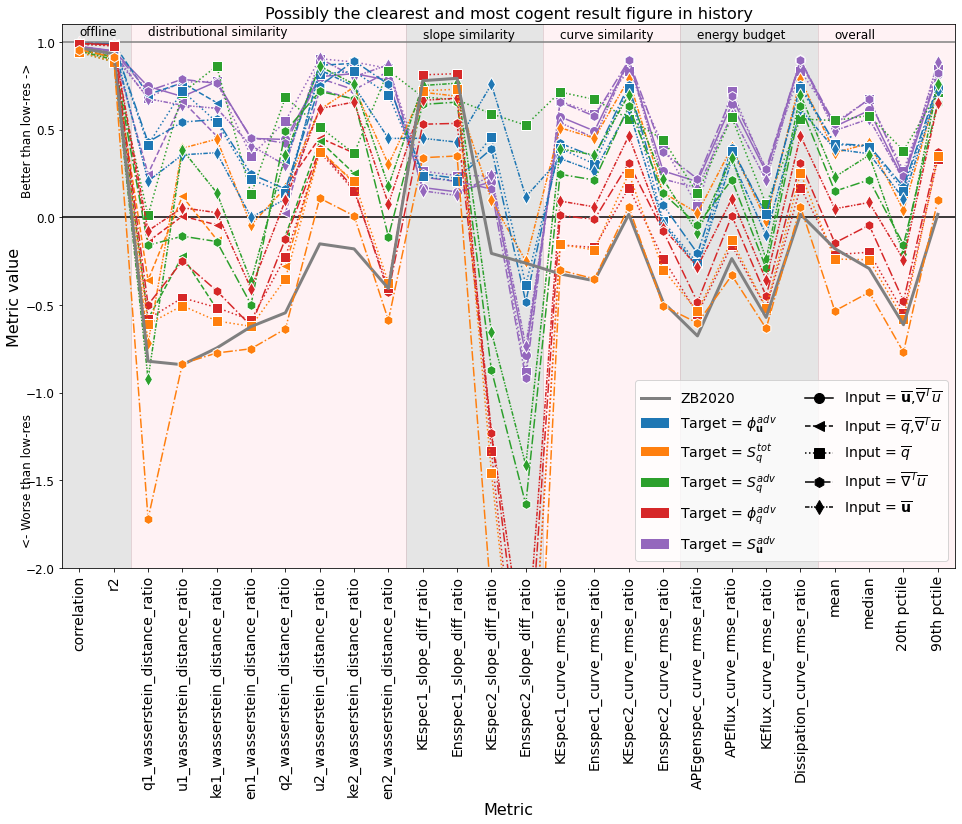

In [21]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
colors = plt.get_cmap('tab10').colors
markers = list(Line2D.filled_markers)[::3]
linestyles = [
    'solid',
    'dashed',
    'dotted',
    'dashdot',
    (0, (3, 1, 1, 1, 1, 1))
]

plt.figure(figsize=(16,10))
plt.axhline(0, color='black')
plt.axhline(1, color='gray')
for row in tab:
    kw = dict(color=colors[ys.index(row['y'])], marker=markers[xs.index(row['x'])], markeredgecolor='white', markersize=10, linestyle=linestyles[xs.index(row['x'])])
                                                                                                                                                 
    if 'zb2020' in row['path']:
        kw['color'] = 'gray'
        kw['linestyle'] = '-'
        kw['lw'] = 3
        kw['marker'] = None

    rng = np.arange(len(mets)+4)
    vals = [row[m] for m in mets]
    plt.plot(vals + [np.mean(vals),np.median(vals),np.percentile(vals,20),np.percentile(vals,80)], **kw)
plt.xticks(rng, mets+['mean','median','20th pctile','90th pctile'], rotation=90, fontsize=14)

plt.legend(handles=[
    Line2D([0],[0],color='gray',ls='solid',lw=3,label="ZB2020")
] + [
    Patch(facecolor=colors[i], label=f"Target = {y}") for i,y in enumerate(ys)
] + [
    Line2D([0],[0],color='black',ls=linestyles[i], marker=markers[i],markersize=10, label=f"Input = {x}") for i,x in enumerate(xs)
] + [
    
], fontsize=14, ncol=2)
plt.ylim(-2,1.1)

plt.axvspan(-0.5,1.5,color='gray',alpha=0.2)
plt.axvspan(1.5,9.5,color='pink',alpha=0.2)
plt.axvspan(9.5,13.5,color='gray',alpha=0.2)
plt.axvspan(13.5,17.5,color='pink',alpha=0.2)
plt.axvspan(17.5,21.5,color='gray',alpha=0.2)
plt.axvspan(21.5,25.5,color='pink',alpha=0.2)

plt.text(0,1.02,"offline",va='bottom')
plt.text(2,1.02,"distributional similarity",va='bottom')
plt.text(10,1.02,"slope similarity")
plt.text(14,1.02,"curve similarity")
plt.text(18,1.02,"energy budget")
plt.text(22,1.02,"overall")
plt.xlim(-0.5,25.5)
plt.title("Possibly the clearest and most cogent result figure in history", fontsize=16)
plt.text( -1.5, 0.5, "Better than low-res ->", ha='center', va='center', rotation=90, fontsize=12)
plt.text( -1.5, -1.5, "<- Worse than low-res", ha='center', va='center', rotation=90, fontsize=12)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Metric value", fontsize=16)

In [22]:
tab2= get_rows(model_paths,metrics=mets, dataset_name='transfer')
tab2 = list(sorted(tab2, key=lambda r: np.median([r[m] for m in mets]), reverse=True))
pd.DataFrame.from_dict(tab2)

x  \
0   $\overline{\mathbf{u}}$,$\overline{\nabla}^T \...   
1                             $\overline{\mathbf{u}}$   
2   $\overline{q}$,$\overline{\nabla}^T \overline{u}$   
3                                      $\overline{q}$   
4                             $\overline{\mathbf{u}}$   
5   $\overline{q}$,$\overline{\nabla}^T \overline{u}$   
6   $\overline{q}$,$\overline{\nabla}^T \overline{u}$   
7   $\overline{q}$,$\overline{\nabla}^T \overline{u}$   
8                  $\overline{\nabla}^T \overline{u}$   
9                  $\overline{\nabla}^T \overline{u}$   
10                            $\overline{\mathbf{u}}$   
11                 $\overline{\nabla}^T \overline{u}$   
12                            $\overline{\mathbf{u}}$   
13                            $\overline{\mathbf{u}}$   
14                                     $\overline{q}$   
15                            $\overline{\mathbf{u}}$   
16                                     $\overline{q}$   
17                                     $\overline{q}$   
18  $\overline{q}$,$\overline{\nabla}^T \overline{u}$   
19                 $\overline{\nabla}^T \overline{u}$   
20                 $\overline{\nabla}^T \overline{u}$   
21                                     $\overline{q}$   

                            y  \
0      $S_{\mathbf{u}}^{adv}$   
1      $S_{\mathbf{u}}^{adv}$   
2   $\phi_{\mathbf{u}}^{adv}$   
3   $\phi_{\mathbf{u}}^{adv}$   
4   $\phi_{\mathbf{u}}^{adv}$   
5      $S_{\mathbf{u}}^{adv}$   
6                 $S_q^{tot}$   
7                 $S_q^{adv}$   
8      $S_{\mathbf{u}}^{adv}$   
9   $\phi_{\mathbf{u}}^{adv}$   
10     $S_{\mathbf{u}}^{adv}$   
11           $\phi_{q}^{adv}$   
12                $S_q^{tot}$   
13           $\phi_{q}^{adv}$   
14     $S_{\mathbf{u}}^{adv}$   
15                $S_q^{adv}$   
16                $S_q^{tot}$   
17           $\phi_{q}^{adv}$   
18           $\phi_{q}^{adv}$   
19                $S_q^{tot}$   
20                $S_q^{adv}$   
21                $S_q^{adv}$   

                                                 path  correlation      r2  \
0   /scratch/zanna/data/pyqg/models/fcnn_u-v-ddx_u...        0.934  -2.347   
1   /scratch/zanna/data/pyqg/models/fcnn_u-v_u_for...        0.932  -2.239   
2   /scratch/zanna/data/pyqg/models/fcnn_q-ddx_u-d...        0.959  -0.433   
3   /scratch/zanna/data/pyqg/models/fcnn_q_uu_subg...        0.894  -0.534   
4   /scratch/zanna/data/pyqg/models/fcnn_u-v_uu_su...        0.961  -0.383   
5   /scratch/zanna/data/pyqg/models/fcnn_q-ddx_u-d...        0.908  -2.623   
6   /scratch/zanna/data/pyqg/models/fcnn_q-ddx_u-d...        0.849  -6.037   
7   /scratch/zanna/data/pyqg/models/fcnn_q-ddx_u-d...        0.852  -6.946   
8   /scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx...        0.925  -3.095   
9   /scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx...        0.965  -0.333   
10         /scratch/zanna/data/pyqg/models/zb2020_1.0        0.964   0.928   
11  /scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx...        0.876 -11.688   
12  /scratch/zanna/data/pyqg/models/fcnn_u-v_q_for...        0.854  -5.629   
13  /scratch/zanna/data/pyqg/models/fcnn_u-v_uq_su...        0.881 -11.443   
14  /scratch/zanna/data/pyqg/models/fcnn_q_u_forci...        0.859  -2.359   
15  /scratch/zanna/data/pyqg/models/fcnn_u-v_q_for...        0.854  -5.884   
16  /scratch/zanna/data/pyqg/models/fcnn_q_q_forci...        0.845  -1.928   
17  /scratch/zanna/data/pyqg/models/fcnn_q_uq_subg...        0.883  -6.721   
18  /scratch/zanna/data/pyqg/models/fcnn_q-ddx_u-d...        0.916 -11.441   
19  /scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx...        0.872  -5.831   
20  /scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx...        0.875  -5.353   
21  /scratch/zanna/data/pyqg/models/fcnn_q_q_forci...        0.838  -2.241   

    q1_wasserstein_distance_ratio  u1_wasserstein_distance_ratio  \
0                        0.533646                      -0.242761   
1                        0.693573                

Text(0, 0.5, 'Metric value')

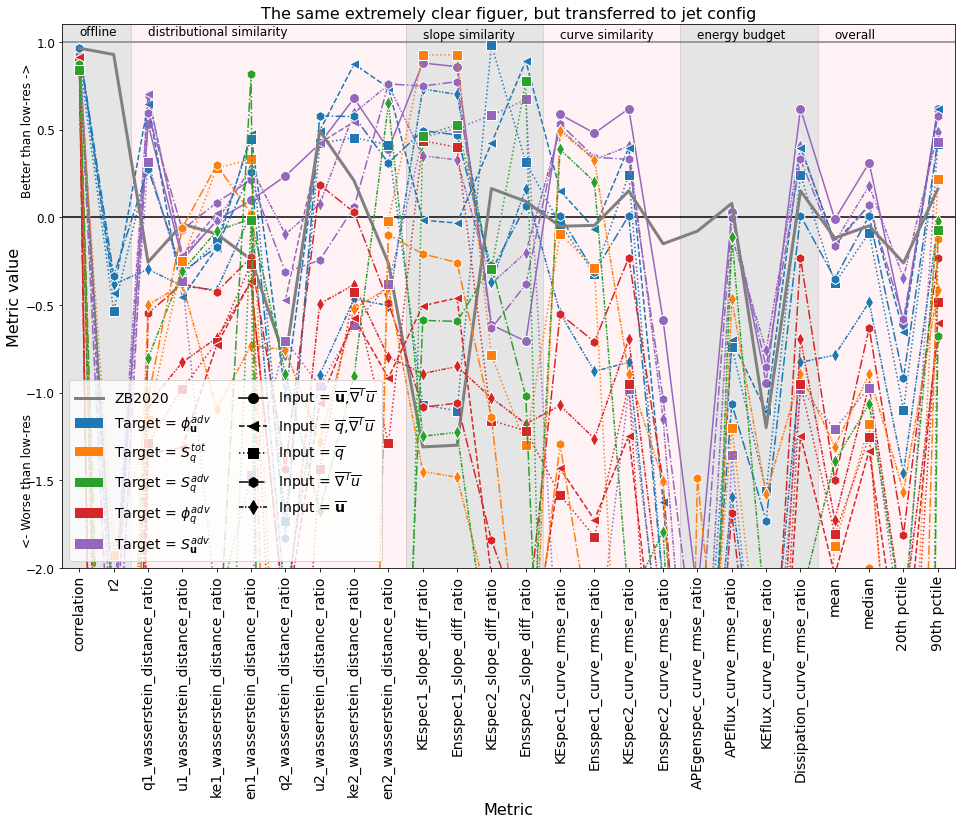

In [40]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
colors = plt.get_cmap('tab10').colors
markers = list(Line2D.filled_markers)[::3]
linestyles = [
    'solid',
    'dashed',
    'dotted',
    'dashdot',
    (0, (3, 1, 1, 1, 1, 1))
]

plt.figure(figsize=(16,10))
plt.axhline(0, color='black')
plt.axhline(1, color='gray')
for row in tab2:
    kw = dict(color=colors[ys.index(row['y'])], marker=markers[xs.index(row['x'])], markeredgecolor='white', markersize=10, linestyle=linestyles[xs.index(row['x'])])
                                                                                                                                                 
    if 'zb2020' in row['path']:
        kw['color'] = 'gray'
        kw['linestyle'] = '-'
        kw['lw'] = 3
        kw['marker'] = None

    rng = np.arange(len(mets)+4)
    vals = [row[m] for m in mets]
    plt.plot(vals + [np.mean(vals),np.median(vals),np.percentile(vals,20),np.percentile(vals,80)], **kw)
plt.xticks(rng, mets+['mean','median','20th pctile','90th pctile'], rotation=90, fontsize=14)

plt.legend(handles=[
    Line2D([0],[0],color='gray',ls='solid',lw=3,label="ZB2020")
] + [
    Patch(facecolor=colors[i], label=f"Target = {y}") for i,y in enumerate(ys)
] + [
    Line2D([0],[0],color='black',ls=linestyles[i], marker=markers[i],markersize=10, label=f"Input = {x}") for i,x in enumerate(xs)
] + [
    
], fontsize=14, ncol=2, loc='lower left')
plt.ylim(-2,1.1)

plt.axvspan(-0.5,1.5,color='gray',alpha=0.2)
plt.axvspan(1.5,9.5,color='pink',alpha=0.2)
plt.axvspan(9.5,13.5,color='gray',alpha=0.2)
plt.axvspan(13.5,17.5,color='pink',alpha=0.2)
plt.axvspan(17.5,21.5,color='gray',alpha=0.2)
plt.axvspan(21.5,25.5,color='pink',alpha=0.2)

plt.text(0,1.02,"offline",va='bottom')
plt.text(2,1.02,"distributional similarity",va='bottom')
plt.text(10,1.02,"slope similarity")
plt.text(14,1.02,"curve similarity")
plt.text(18,1.02,"energy budget")
plt.text(22,1.02,"overall")
plt.xlim(-0.5,25.5)
plt.title("The same extremely clear figuer, but transferred to jet config", fontsize=16)
plt.text( -1.5, 0.5, "Better than low-res ->", ha='center', va='center', rotation=90, fontsize=12)
plt.text( -1.5, -1.5, "<- Worse than low-res", ha='center', va='center', rotation=90, fontsize=12)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Metric value", fontsize=16)

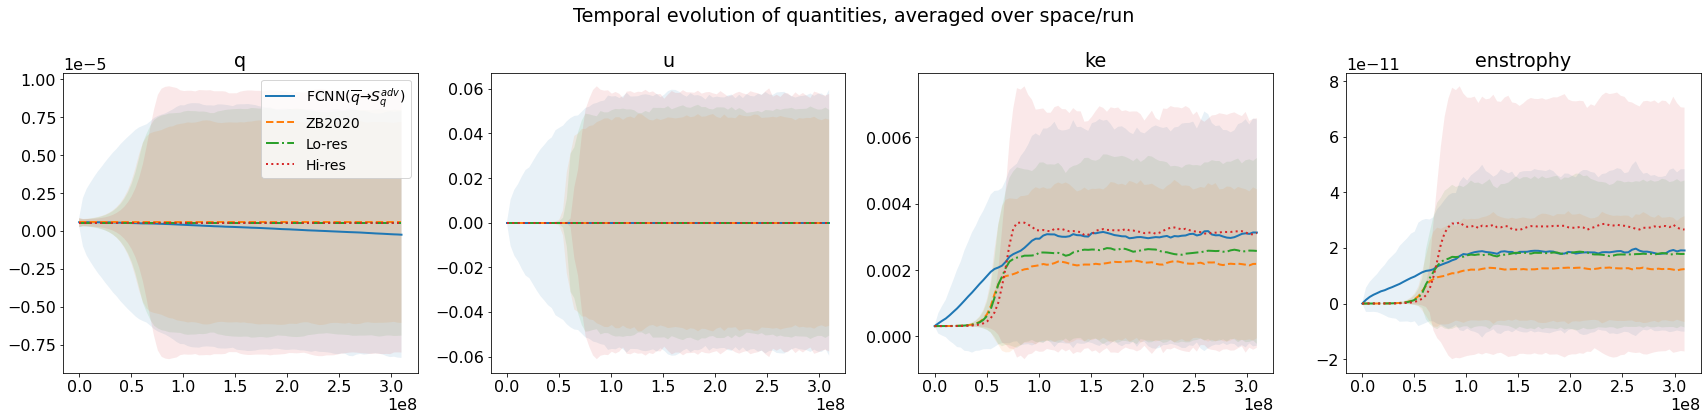

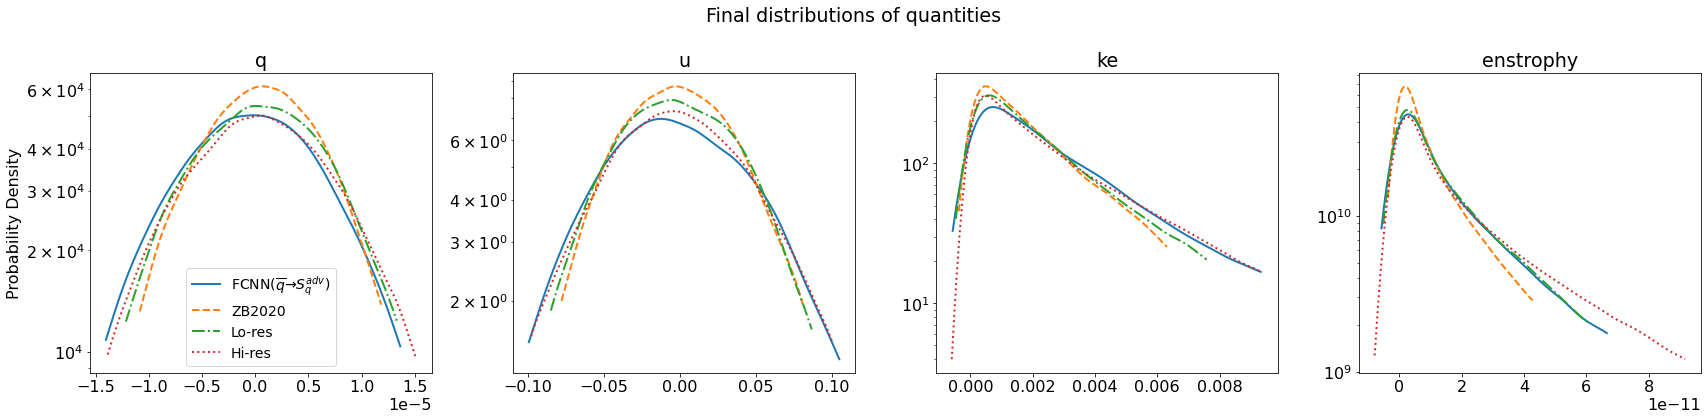

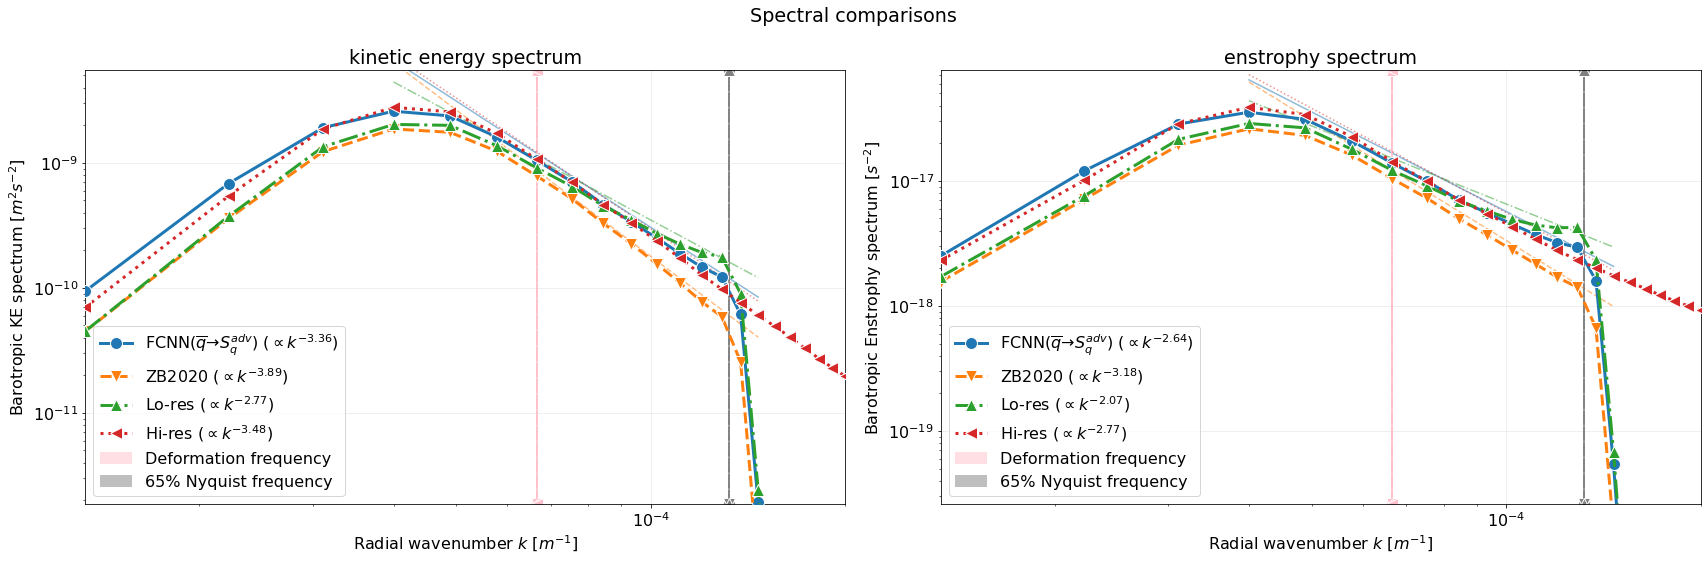

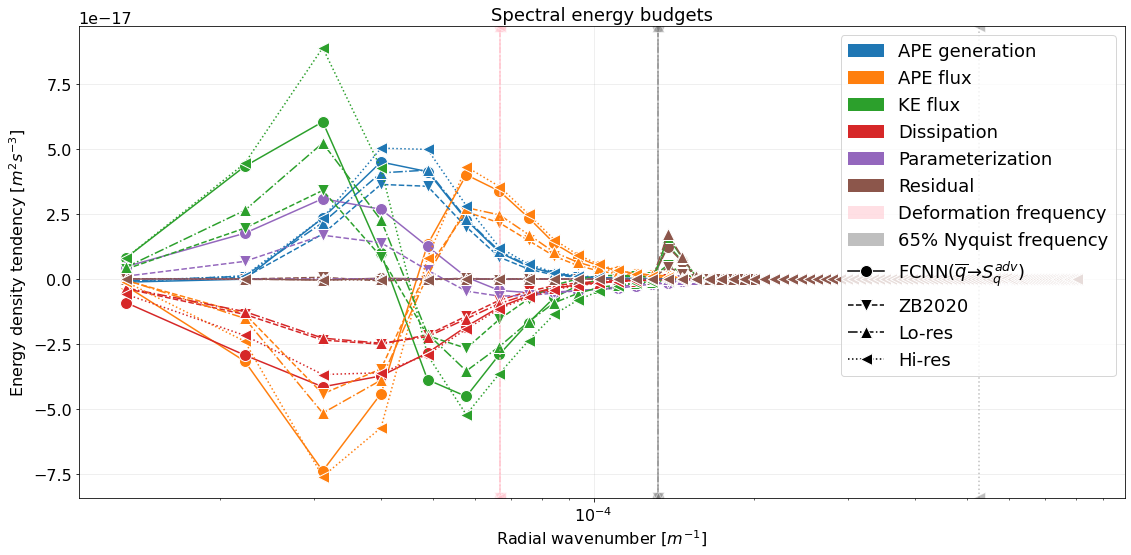

In [174]:
pse.compare_simulations(
    sims_for(tab[4]['path']),
    sims_for(model_paths[-1]),
    lores_test,
    hires_test,
    show_quantities=False
)

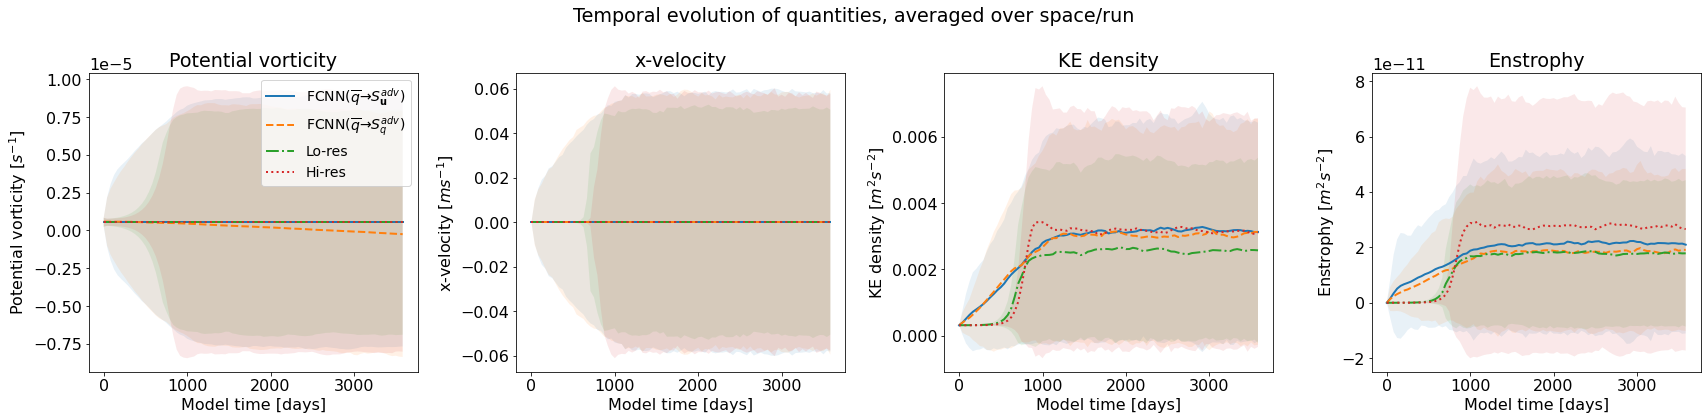

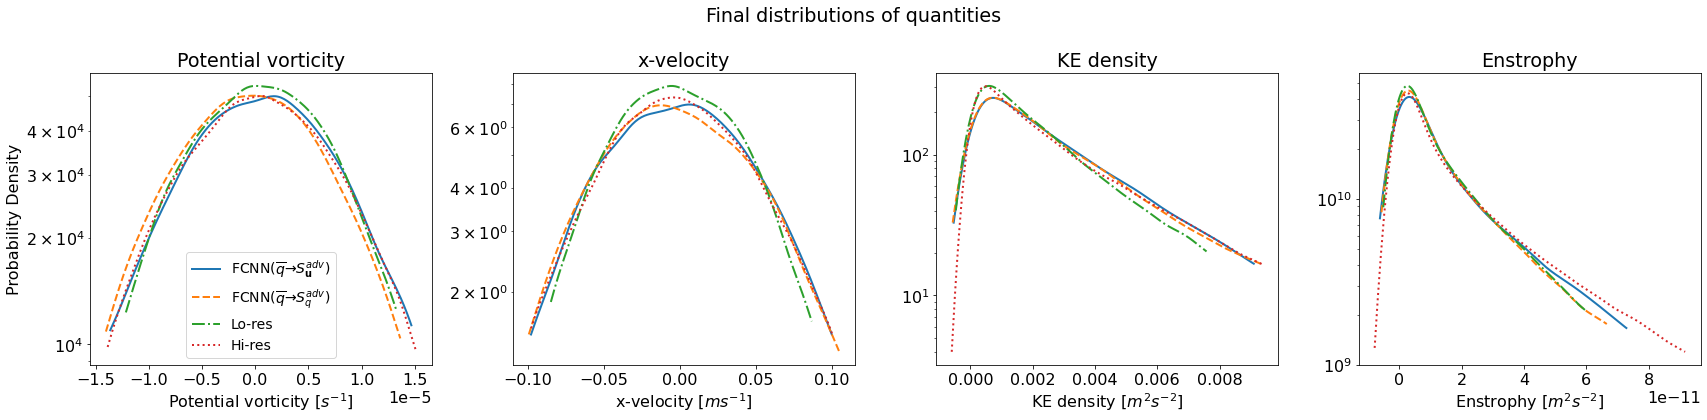

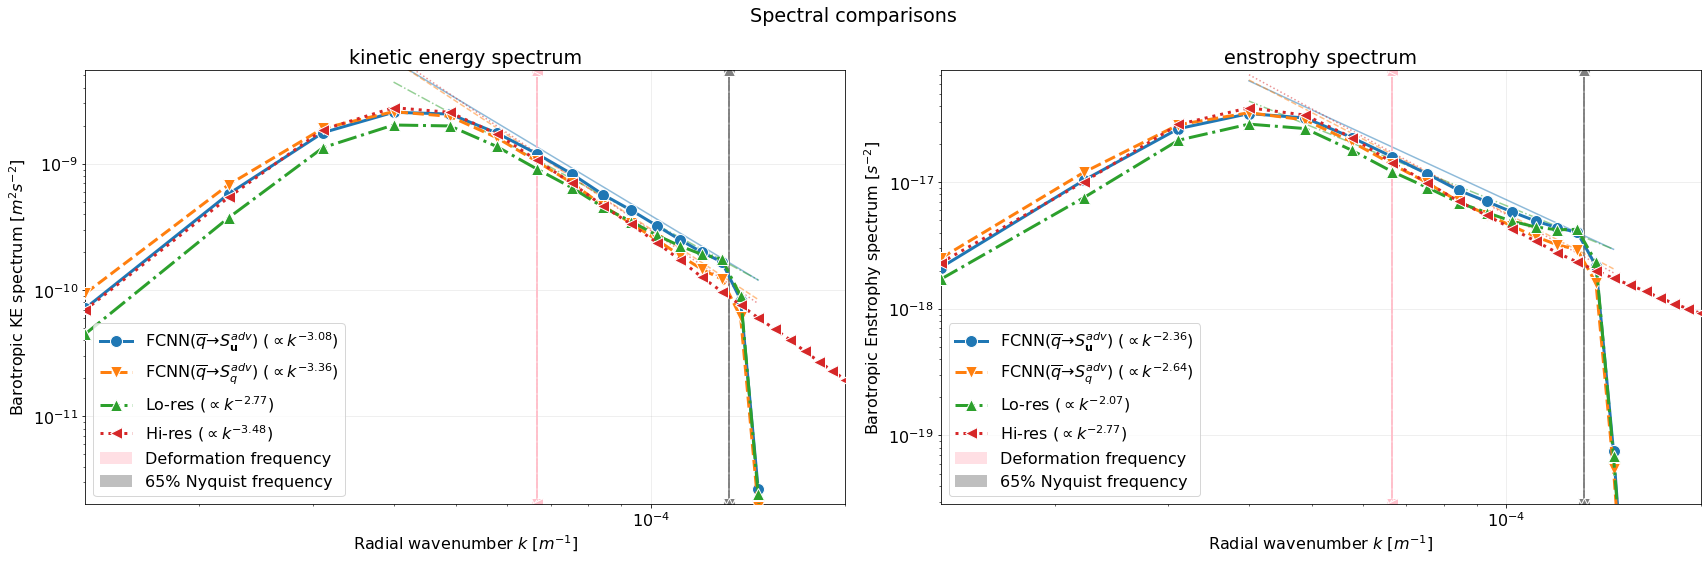

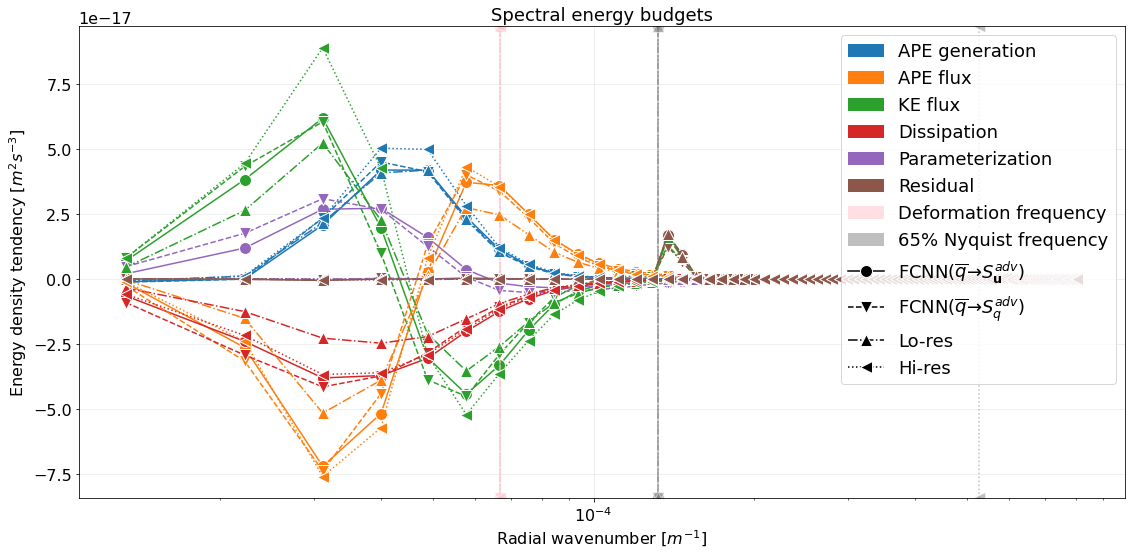

In [191]:
pse.compare_simulations(
    sims_for('/scratch/zanna/data/pyqg/models/fcnn_q_u_forcing_advection-v_forcing_advection_zeromean1_layerwise00/0'),
    sims_for('/scratch/zanna/data/pyqg/models/fcnn_q_q_forcing_advection_zeromean1_layerwise00/0'),
    lores_test,
    hires_test,
    show_quantities=False
)

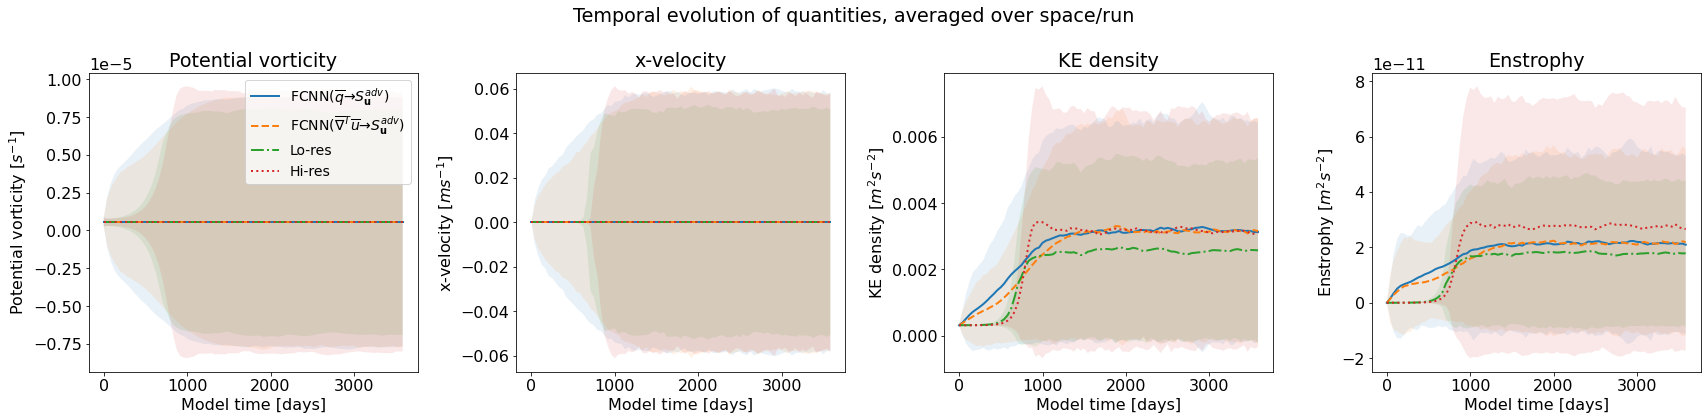

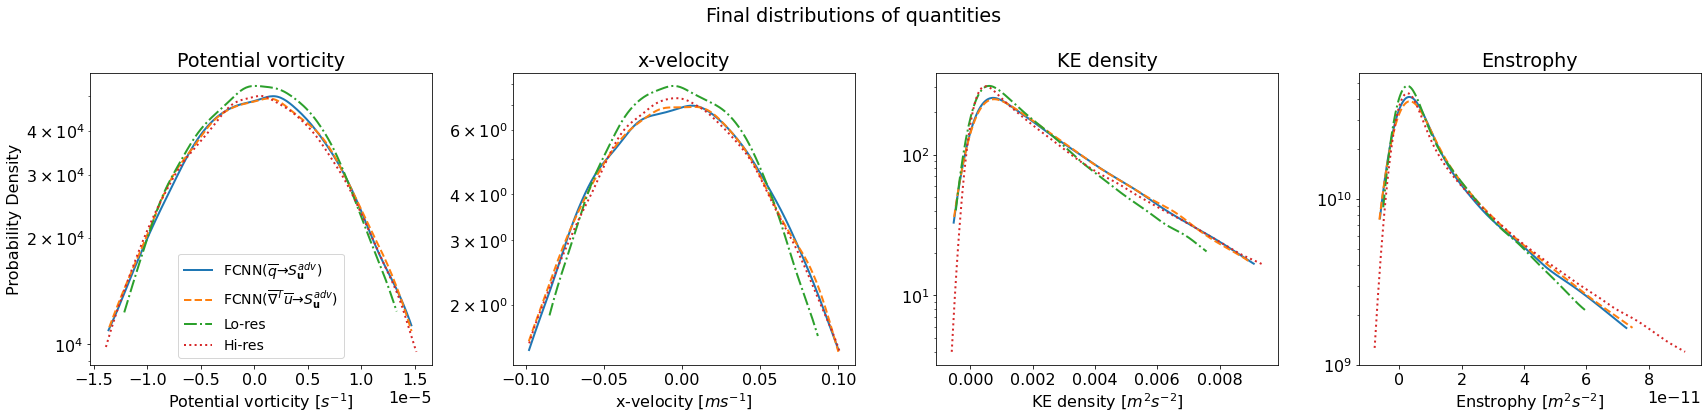

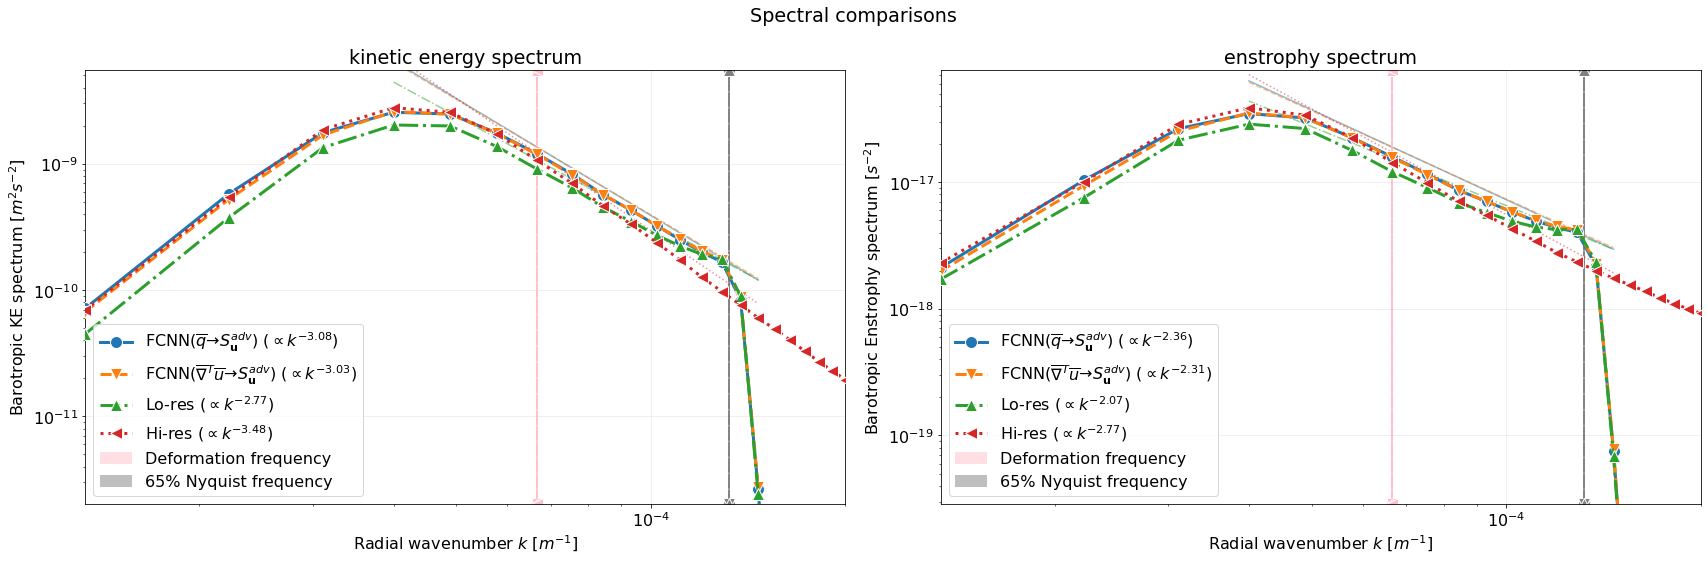

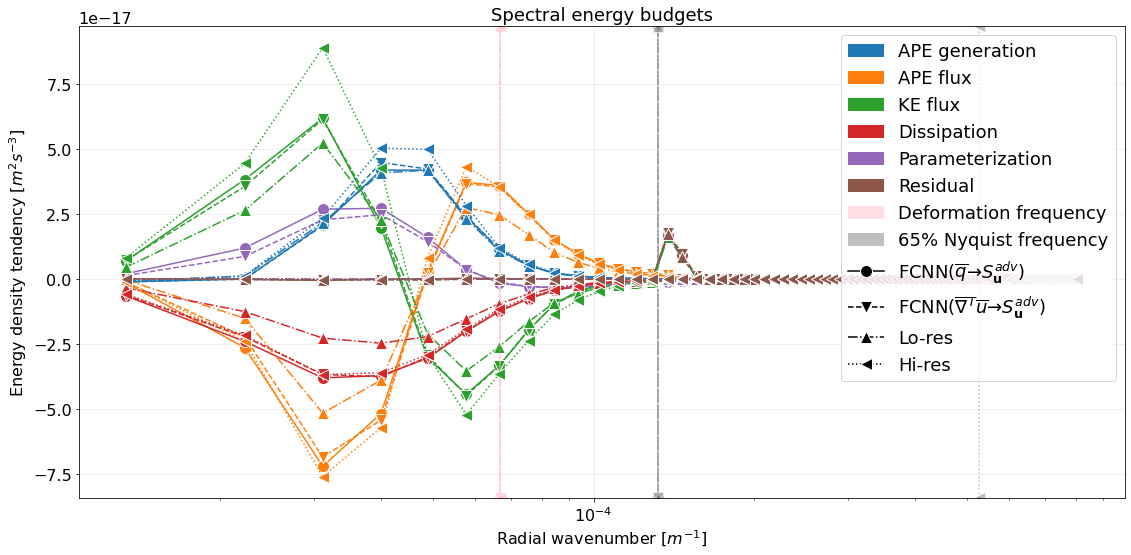

In [192]:
pse.compare_simulations(
    sims_for('/scratch/zanna/data/pyqg/models/fcnn_q_u_forcing_advection-v_forcing_advection_zeromean1_layerwise00/0'),
    sims_for('/scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx_v-ddy_u-ddy_v_u_forcing_advection-v_forcing_advection_zeromean1_layerwise00/0'),
    lores_test,
    hires_test,
    show_quantities=False
)

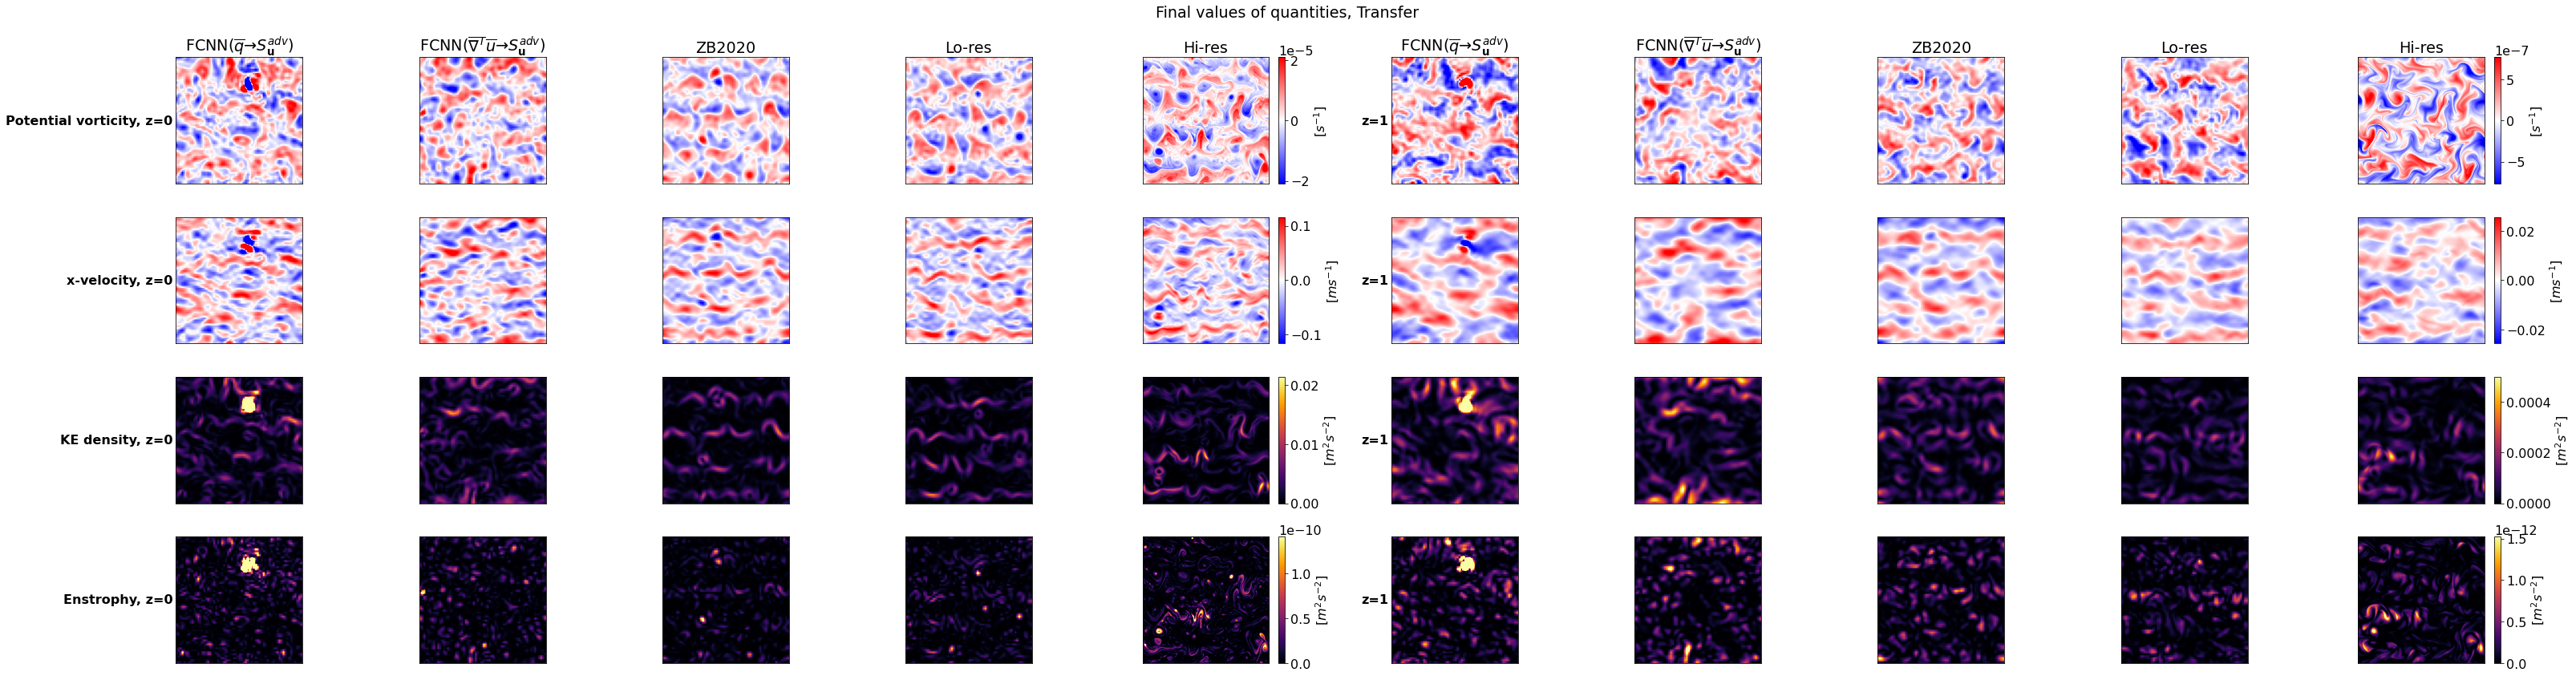

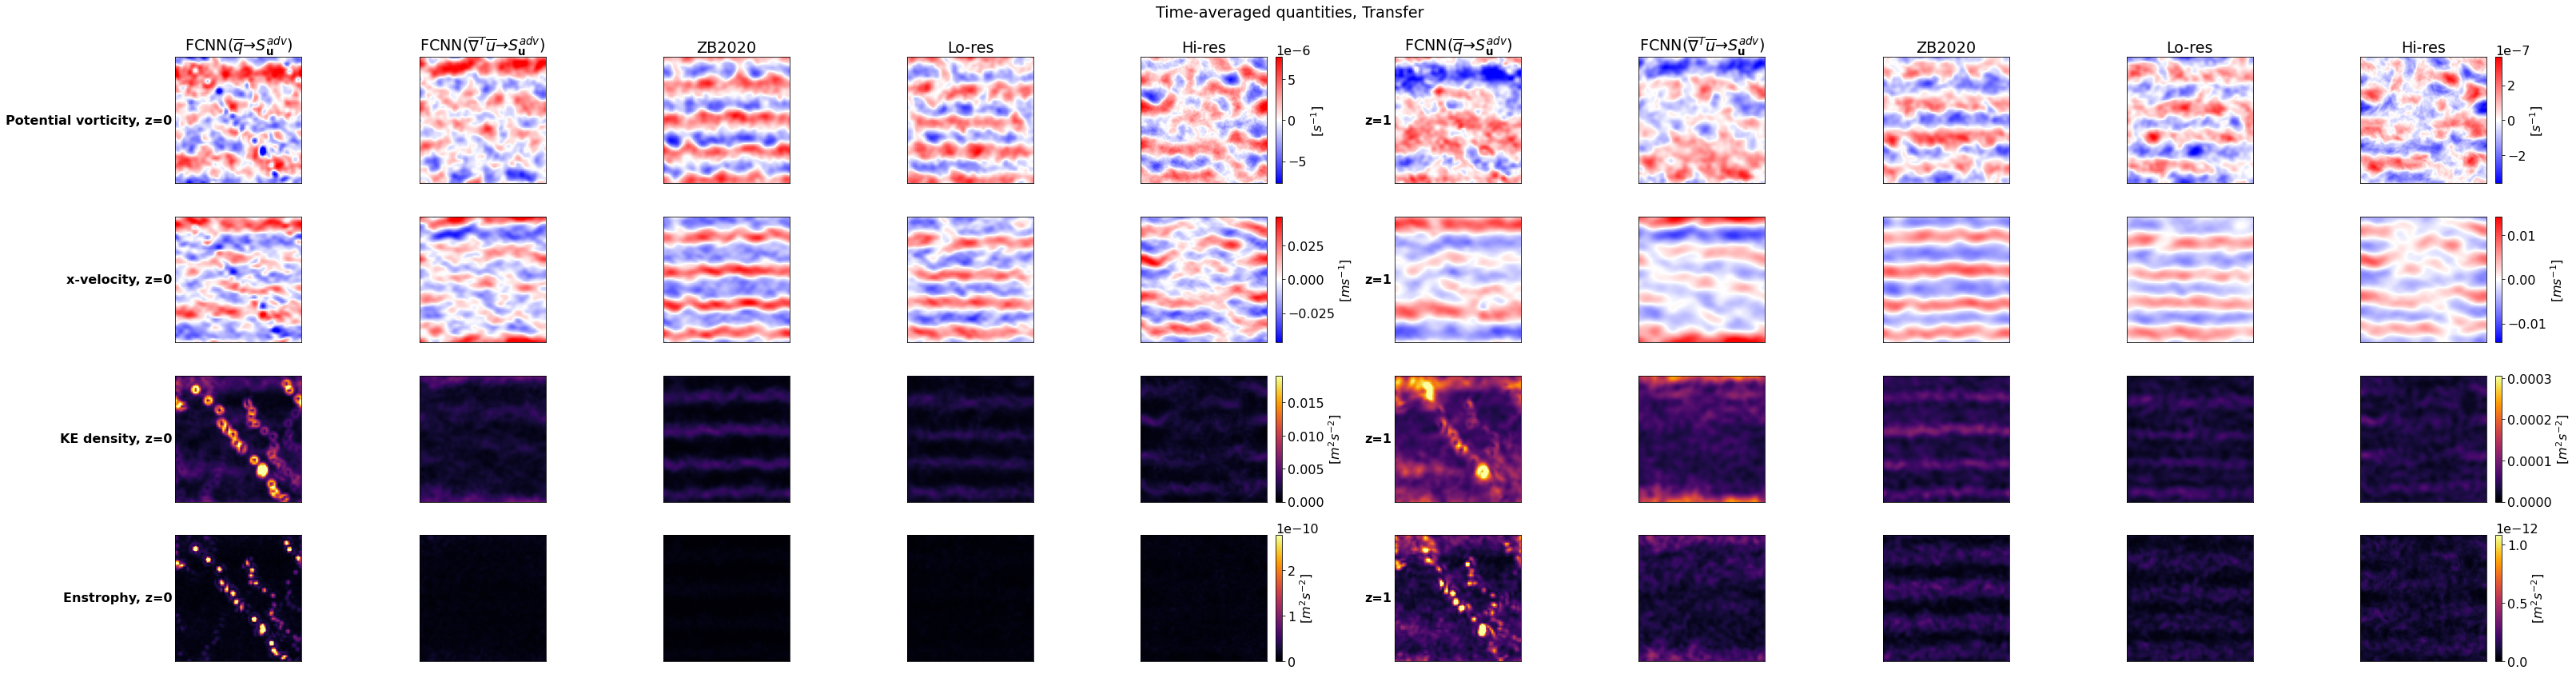

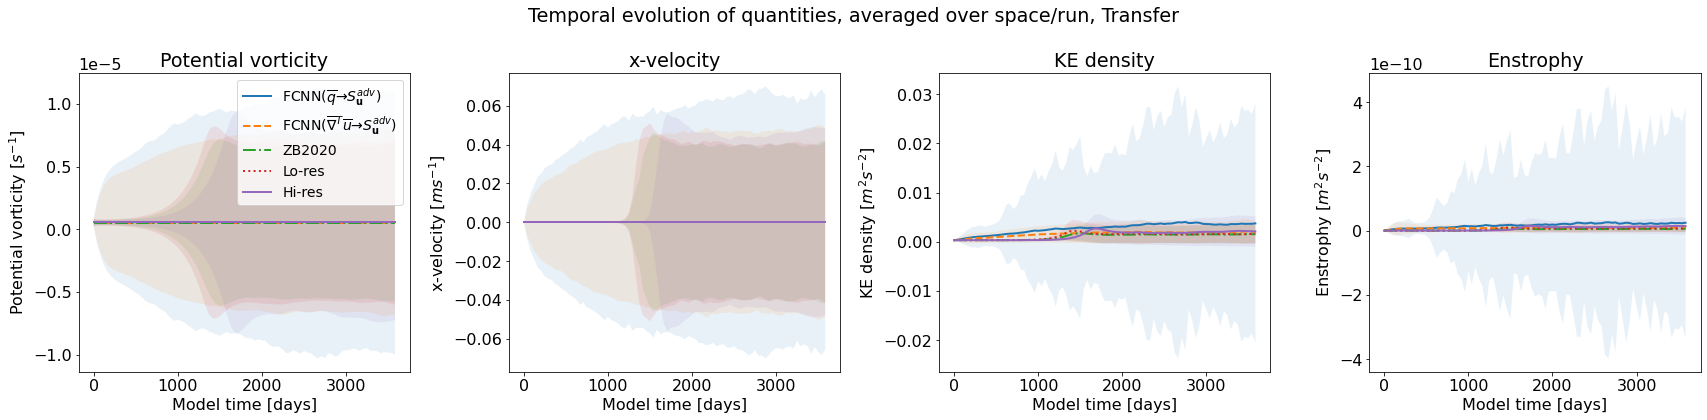

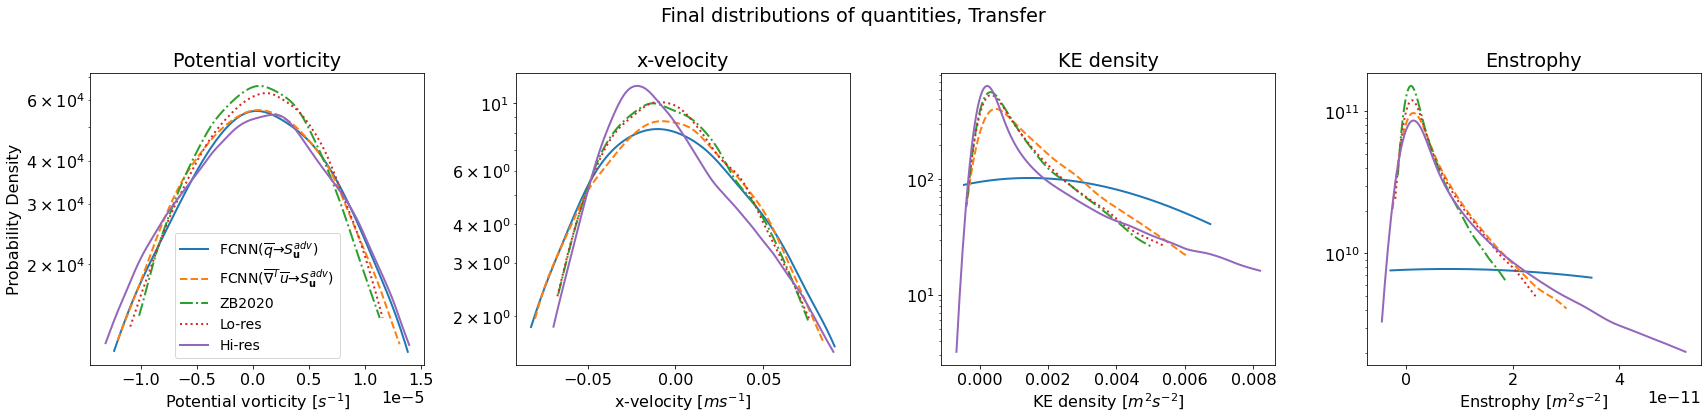

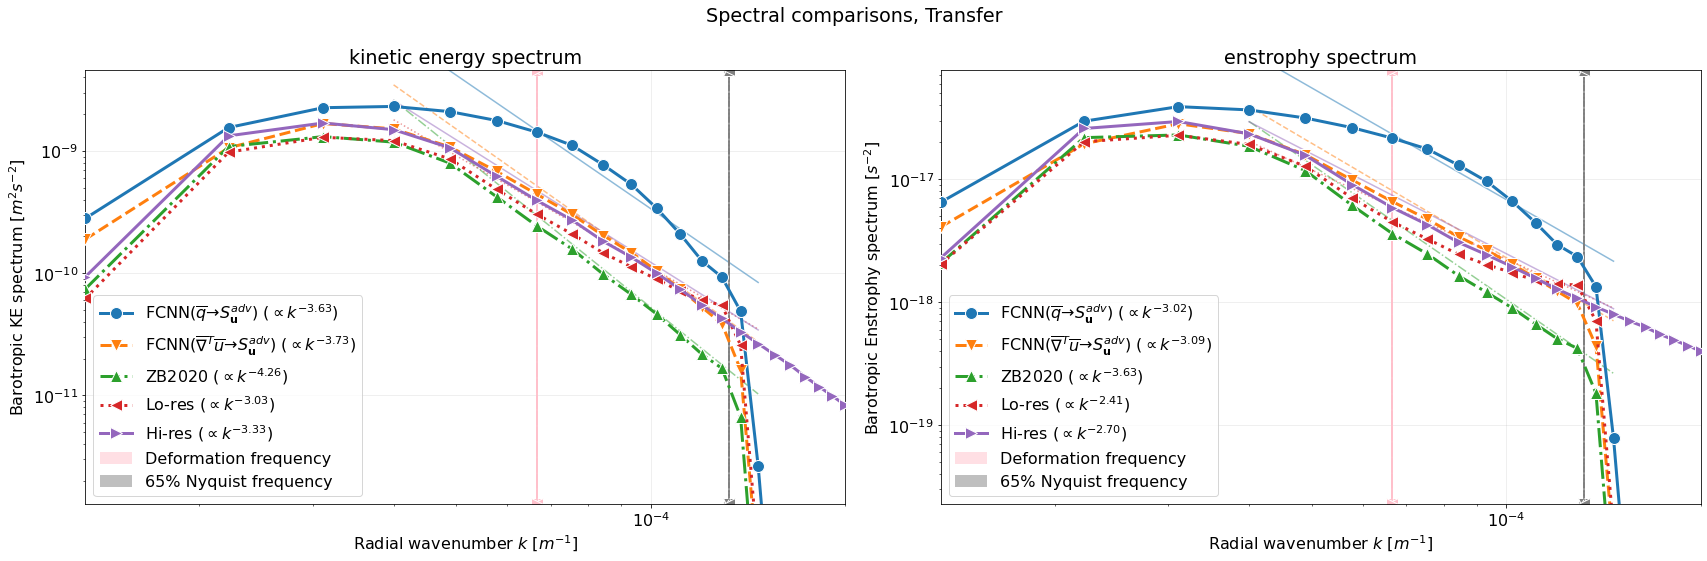

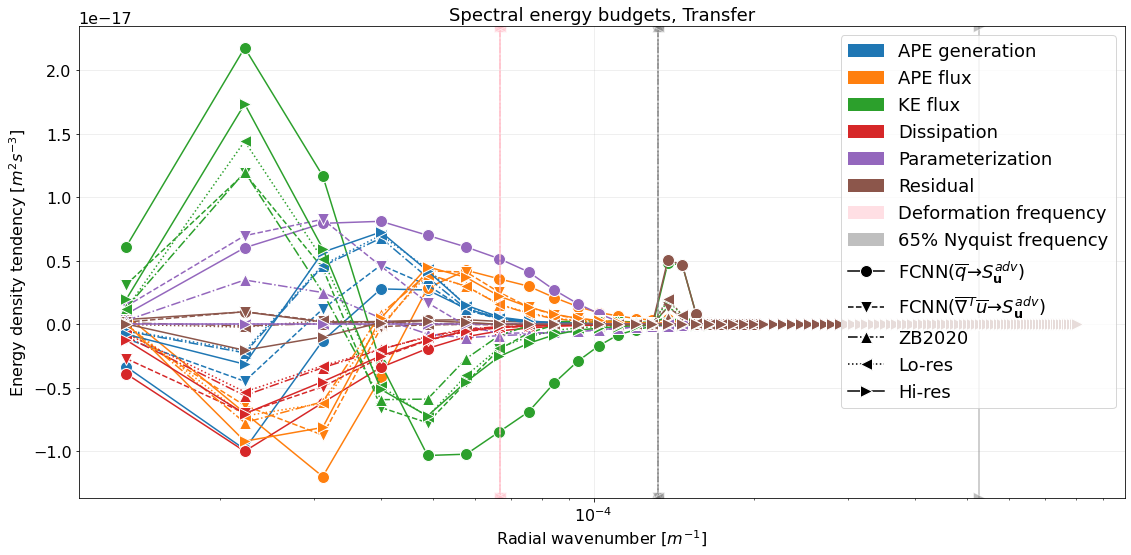

In [190]:
pse.compare_simulations(
    sims_for('/scratch/zanna/data/pyqg/models/fcnn_q_u_forcing_advection-v_forcing_advection_zeromean1_layerwise00/0', dataset_name='transfer'),
    sims_for('/scratch/zanna/data/pyqg/models/fcnn_ddx_u-ddx_v-ddy_u-ddy_v_u_forcing_advection-v_forcing_advection_zeromean1_layerwise00/0', dataset_name='transfer'),
     sims_for(model_paths[-1], dataset_name='transfer'),
    lores_xfer,
    hires_xfer,

    title_suffix=', Transfer'
)

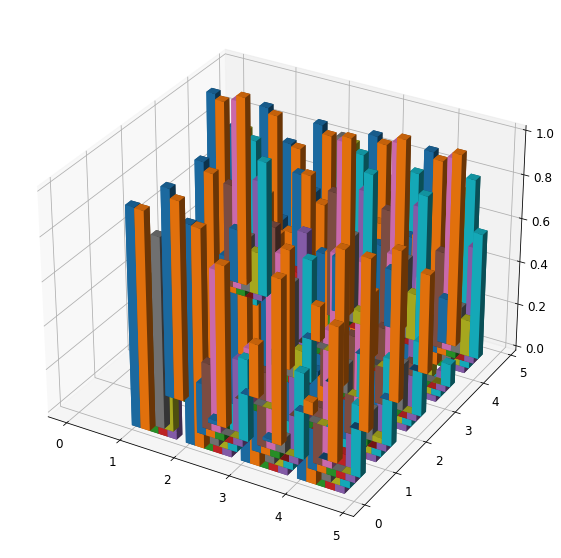

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

sq_size = int(np.ceil(np.sqrt(len(mets))))

for k, met in enumerate(mets):
    
    bar_x = []
    bar_y = []
    bar_z = []
        
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            try:
                row = next(t for t in tab if t['x']==x and t['y']==y)
                bar_x.append(i + (k % sq_size)/(sq_size+1))
                bar_y.append(j + (k // sq_size)/(sq_size+1))
                bar_z.append(max(row[met],0))
            except:
                continue
        
    ax.bar3d(bar_x, bar_y, np.zeros_like(bar_z), 1/(sq_size+1), 1/(sq_size+1),  bar_z, shade=True)
    ax.set_zlim(0,1)

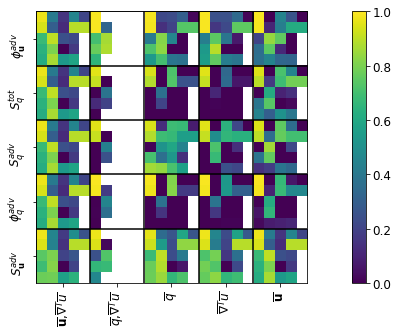

In [32]:
fig = plt.figure(figsize=(16,5))

sq_size = int(np.ceil(np.sqrt(len(mets))))

img = np.zeros((
    
    len(ys)*sq_size,
    len(xs)*sq_size,
)).astype(float) * np.nan


for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        try:
            row = next(t for t in tab if t['x']==x and t['y']==y)
        except:
            next
        for k, met in enumerate(mets):
            xx = i*sq_size + (k // sq_size)
            yy = j*sq_size + (k % sq_size)
            img[yy][xx] = row[met]
                
                
for i in range(len(ys)):
    plt.axhline(i*sq_size-0.5, color='black')
for i in range(len(xs)):
    plt.axvline(i*sq_size-0.5, color='black')
    
plt.xticks((np.arange(len(xs))+0.4)*sq_size, xs, rotation=90)
    
plt.yticks((np.arange(len(ys))+0.4)*sq_size, ys, rotation=90)
plt.imshow(img, vmax=1, vmin=0)
plt.colorbar()

In [33]:
df = construct_table(model_paths, dataset_name='test')
df

y                                                    $S_q^{adv}$         \
                                                   x correlation     r2   
0                            $\overline{\mathbf{u}}$       0.948  0.899   
1  $\overline{\mathbf{u}}$,$\overline{\nabla}^T \...         NaN    NaN   
2                 $\overline{\nabla}^T \overline{u}$       0.955  0.912   
3                                     $\overline{q}$       0.941  0.886   
4  $\overline{q}$,$\overline{\nabla}^T \overline{u}$       0.956  0.915   

y $S_q^{tot}$        $S_{\mathbf{u}}^{adv}$         $\phi_{\mathbf{u}}^{adv}$  \
  correlation     r2            correlation      r2               correlation   
0       0.947  0.898                  0.967  0.9355                     0.991   
1         NaN    NaN                  0.974  0.9490                       NaN   
2       0.955  0.913                  0.973  0.9460                     0.991   
3       0.941  0.886                  0.959  0.9200                     0.986   
4       0.955  0.912                  0.973  0.9470                     0.992   

y        $\phi_{q}^{adv}$         
      r2      correlation     r2  
0  0.988            0.991  0.983  
1    NaN              NaN    NaN  
2  0.989            0.991  0.983  
3  0.982            0.987  0.976  
4  0.989            0.993  0.986

In [34]:
print(df.to_latex(escape=False, index=False, multirow=True, multicolumn_format='c|',column_format='|'+'|'.join('c' for _ in df.columns)+'|'))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
                                                   & \multicolumn{2}{c|}{$S_q^{adv}$} & \multicolumn{2}{c|}{$S_q^{tot}$} & \multicolumn{2}{c|}{$S_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{q}^{adv}$} \\
                                                 x & correlation &    r2 & correlation &    r2 &            correlation &     r2 &               correlation &    r2 &      correlation &    r2 \\
\midrule
                           $\overline{\mathbf{u}}$ &       0.948 & 0.899 &       0.947 & 0.898 &                  0.967 & 0.9355 &                     0.991 & 0.988 &            0.991 & 0.983 \\
$\overline{\mathbf{u}}$,$\overline{\nabla}^T \o... &         NaN &   NaN &         NaN &   NaN &                  0.974 & 0.9490 &                       NaN &   NaN &              NaN &   NaN \\
                $\overline{\nabla}^T \overline{u}$ &       0.955 & 0.912 &       0.955 & 0.913 & 

In [36]:
df = construct_table(model_paths, dataset_name='transfer')
df

y                                                    $S_q^{adv}$         \
                                                   x correlation     r2   
0                            $\overline{\mathbf{u}}$       0.854 -5.884   
1  $\overline{\mathbf{u}}$,$\overline{\nabla}^T \...         NaN    NaN   
2                 $\overline{\nabla}^T \overline{u}$       0.875 -5.353   
3                                     $\overline{q}$       0.838 -2.241   
4  $\overline{q}$,$\overline{\nabla}^T \overline{u}$       0.852 -6.946   

y $S_q^{tot}$        $S_{\mathbf{u}}^{adv}$         $\phi_{\mathbf{u}}^{adv}$  \
  correlation     r2            correlation      r2               correlation   
0       0.854 -5.629                  0.948 -0.6555                     0.961   
1         NaN    NaN                  0.934 -2.3470                       NaN   
2       0.872 -5.831                  0.925 -3.0950                     0.965   
3       0.845 -1.928                  0.859 -2.3590                     0.894   
4       0.849 -6.037                  0.908 -2.6230                     0.959   

y        $\phi_{q}^{adv}$          
      r2      correlation      r2  
0 -0.383            0.881 -11.443  
1    NaN              NaN     NaN  
2 -0.333            0.876 -11.688  
3 -0.534            0.883  -6.721  
4 -0.433            0.916 -11.441

In [37]:
print(df.to_latex(escape=False, index=False, multirow=True, multicolumn_format='c|',column_format='|'+'|'.join('c' for _ in df.columns)+'|'))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
                                                   & \multicolumn{2}{c|}{$S_q^{adv}$} & \multicolumn{2}{c|}{$S_q^{tot}$} & \multicolumn{2}{c|}{$S_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{q}^{adv}$} \\
                                                 x & correlation &     r2 & correlation &     r2 &            correlation &      r2 &               correlation &     r2 &      correlation &      r2 \\
\midrule
                           $\overline{\mathbf{u}}$ &       0.854 & -5.884 &       0.854 & -5.629 &                  0.948 & -0.6555 &                     0.961 & -0.383 &            0.881 & -11.443 \\
$\overline{\mathbf{u}}$,$\overline{\nabla}^T \o... &         NaN &    NaN &         NaN &    NaN &                  0.934 & -2.3470 &                       NaN &    NaN &              NaN &     NaN \\
                $\overline{\nabla}^T \overline{u}$ &       0.875 & -5.353 &    

In [123]:
print(df.to_latex(escape=False, index=False, multirow=True, multicolumn_format='c|',column_format='|'+'|'.join('c' for _ in df.columns)+'|',float_format="%.2f" ).replace('\mathrm{Sim}^{\mathrm{dist}}_',''))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
                                       & \multicolumn{4}{c|}{$S_q^{adv}$} & \multicolumn{4}{c|}{$S_q^{tot}$} & \multicolumn{4}{c|}{$S_{\mathbf{u}}^{adv}$} & \multicolumn{4}{c|}{$\phi_{\mathbf{u}}^{adv}$} & \multicolumn{4}{c|}{$\phi_{q}^{adv}$} \\
                                    xy & ${u_1}$ & ${u_2}$ & ${v_1}$ & ${v_2}$ & ${u_1}$ & ${u_2}$ & ${v_1}$ & ${v_2}$ & ${u_1}$ & ${u_2}$ & ${v_1}$ & ${v_2}$ & ${u_1}$ & ${u_2}$ & ${v_1}$ & ${v_2}$ & ${u_1}$ & ${u_2}$ & ${v_1}$ & ${v_2}$ \\
\midrule
               $\overline{\mathbf{u}}$ &                                -0.25 &                                 0.37 &                                -0.50 &                                 0.28 &                                -4.39 &                                -1.06 &                                -7.21 &                                -4.44 &                                 0.79 &                                 0.69 &  

In [127]:
df = construct_table(dataset_name='test',metrics=['KEspec1_mean_difference_ratio','KEspec2_mean_difference_ratio'])
print(df.to_latex(escape=False, index=False, multirow=True, multicolumn_format='c|',column_format='|'+'|'.join('c' for _ in df.columns)+'|',float_format="%.2f" ))
df

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
                                       & \multicolumn{2}{c|}{$S_q^{adv}$} & \multicolumn{2}{c|}{$S_q^{tot}$} & \multicolumn{2}{c|}{$S_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{q}^{adv}$} \\
                                    xy & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$ \\
\midrule
               $\overline{\mathbf{u}}$ &                                            0.09 &                                            0.66 &            

y                                          \
                                       xy   
0                 $\overline{\mathbf{u}}$   
1                          $\overline{q}$   
2  $\overline{q}$,$\overline{\mathbf{u}}$   

y                                     $S_q^{adv}$  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$   
0                                        0.094937   
1                                        0.974150   
2                                        0.848309   

y                                                  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$   
0                                        0.662680   
1                                        0.744917   
2                                        0.834895   

y                                     $S_q^{tot}$  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$   
0                                      -14.928757   
1                                        0.108022   
2                                      -12.595372   

y                                                  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$   
0                                       -7.646525   
1                                        0.577880   
2                                       -6.607291   

y                          $S_{\mathbf{u}}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$   
0                                        0.828770   
1                                        0.788443   
2                                        0.759620   

y                                                  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$   
0                                        0.989895   
1                                        0.984779   
2                                        0.973852   

y                       $\phi_{\mathbf{u}}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$   
0                                        0.443549   
1                                        0.682626   
2                                        0.429267   

y                                                  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$   
0                                        0.824915   
1                                        0.955938   
2                                        0.775182   

y                                $\phi_{q}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$   
0                                       -0.674468   
1                                        0.980179   
2                                      -15.960701   

y                                                  
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_2}$  
0                                        0.143534  
1                                        0.904663  
2                                       -8.168571

In [128]:
df = construct_table(dataset_name='test',metrics=['KEspec1_loglog_slope_difference_ratio','KEspec2_loglog_slope_difference_ratio'])
print(df.to_latex(escape=False, index=False, multirow=True, multicolumn_format='c|',column_format='|'+'|'.join('c' for _ in df.columns)+'|',float_format="%.2f" ))
df

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
                                       & \multicolumn{2}{c|}{$S_q^{adv}$} & \multicolumn{2}{c|}{$S_q^{tot}$} & \multicolumn{2}{c|}{$S_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{q}^{adv}$} \\
                                    xy & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$ \\
\midrule
               $\overline{\mathbf{u}}$ &                                            0.27 &                                           -2.81 &            

y                                          \
                                       xy   
0                 $\overline{\mathbf{u}}$   
1                          $\overline{q}$   
2  $\overline{q}$,$\overline{\mathbf{u}}$   

y                                     $S_q^{adv}$  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                        0.266740   
1                                        0.808053   
2                                        0.388608   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$   
0                                       -2.811060   
1                                       -0.205336   
2                                       -1.858986   

y                                     $S_q^{tot}$  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                       -0.224209   
1                                        0.316806   
2                                        0.784995   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$   
0                                       -2.981016   
1                                       -3.470596   
2                                       -6.779525   

y                          $S_{\mathbf{u}}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                        0.528991   
1                                        0.480545   
2                                        0.695939   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$   
0                                        0.866904   
1                                        0.847903   
2                                        0.760323   

y                       $\phi_{\mathbf{u}}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                        0.294804   
1                                        0.413027   
2                                        0.470660   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$   
0                                        0.713703   
1                                        0.792898   
2                                        0.980198   

y                                $\phi_{q}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                        0.025558   
1                                        0.967517   
2                                       -3.701665   

y                                                  
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$  
0                                       -4.834423  
1                                       -0.665180  
2                                       -4.654026

In [159]:
df = construct_table(dataset_name='transfer',metrics=['KEspec1_loglog_slope_difference_ratio','KEspec2_loglog_slope_difference_ratio'])
print(df.to_latex(escape=False, index=False, multirow=True, multicolumn_format='c|',column_format='|'+'|'.join('c' for _ in df.columns)+'|',float_format="%.2f" ))
df

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
                                       & \multicolumn{2}{c|}{$S_q^{adv}$} & \multicolumn{2}{c|}{$S_q^{tot}$} & \multicolumn{2}{c|}{$S_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{q}^{adv}$} \\
                                    xy & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$ \\
\midrule
               $\overline{\mathbf{u}}$ &                                           -1.28 &                                           -0.49 &            

y                                          \
                                       xy   
0                 $\overline{\mathbf{u}}$   
1                          $\overline{q}$   
2  $\overline{q}$,$\overline{\mathbf{u}}$   

y                                     $S_q^{adv}$  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                       -1.281774   
1                                        0.137127   
2                                       -1.496692   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$   
0                                       -0.493042   
1                                       -0.197055   
2                                        0.465849   

y                                     $S_q^{tot}$  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                       -4.610226   
1                                       -1.495984   
2                                        0.454833   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$   
0                                       -6.250319   
1                                       -4.057903   
2                                       -1.801083   

y                          $S_{\mathbf{u}}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                        0.145501   
1                                        0.590152   
2                                       -0.314173   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$   
0                                       -2.766188   
1                                       -0.566085   
2                                       -2.627302   

y                       $\phi_{\mathbf{u}}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                        0.490037   
1                                        0.483190   
2                                        0.965988   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$   
0                                       -1.995968   
1                                       -0.250630   
2                                       -1.550680   

y                                $\phi_{q}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                       -3.503465   
1                                       -0.829605   
2                                       -6.131065   

y                                                  
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_2}$  
0                                       -4.221412  
1                                       -4.527877  
2                                       -0.705850

In [288]:
df = construct_table(dataset_name='transfer',metrics=['KEspec1_mean_difference_ratio','KEspec1_loglog_slope_difference_ratio'])
print(df.to_latex(escape=False, index=False, multirow=True, multicolumn_format='c|',column_format='|'+'|'.join('c' for _ in df.columns)+'|',float_format="%.2f" ))
df

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
                                       & \multicolumn{2}{c|}{$S_q^{adv}$} & \multicolumn{2}{c|}{$S_q^{tot}$} & \multicolumn{2}{c|}{$S_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{\mathbf{u}}^{adv}$} & \multicolumn{2}{c|}{$\phi_{q}^{adv}$} \\
                                    xy & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$ & $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$ \\
\midrule
               $\overline{\mathbf{u}}$ &                                          -19.31 &                                           -1.28 &            

y                                          \
                                       xy   
0                 $\overline{\mathbf{u}}$   
1                          $\overline{q}$   
2  $\overline{q}$,$\overline{\mathbf{u}}$   

y                                     $S_q^{adv}$  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$   
0                                      -19.305909   
1                                     -120.469705   
2                                     -171.765754   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                       -1.281774   
1                                        0.137127   
2                                       -1.496692   

y                                     $S_q^{tot}$  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$   
0                                       -4.527605   
1                                       -1.506713   
2                                      -37.104748   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                       -4.610226   
1                                       -1.495984   
2                                        0.454833   

y                          $S_{\mathbf{u}}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$   
0                                        0.352832   
1                                        0.687970   
2                                       -3.297137   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                        0.145501   
1                                        0.590152   
2                                       -0.314173   

y                       $\phi_{\mathbf{u}}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$   
0                                       -0.374879   
1                                       -0.229931   
2                                       -0.801043   

y                                                  \
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$   
0                                        0.490037   
1                                        0.483190   
2                                        0.965988   

y                                $\phi_{q}^{adv}$  \
  $\mathrm{Sim}^{\mathrm{curve}}_{\mathrm{KE}_1}$   
0                                       -2.826406   
1                                        0.373070   
2                                      -18.183129   

y                                                  
  $\mathrm{Sim}^{\mathrm{slope}}_{\mathrm{KE}_1}$  
0                                       -3.503465  
1                                       -0.829605  
2                                       -6.131065